# Estimation of degree of sea ice ridging in the Bay of Bothnia basedon geolocated photon heights from ICESat-2
By Renée Mie Fredensborg Hansen at Aalto University, DTU and FMI 

This project utilises ICESat-2 data products to estiamte DIR in the Bay of Bothnia.  

## Data products used in this project: 
- ATL03: Geolocated photon data product
- FIS provided Ice Charts

## File naming convention of ICESat-2: 
Naming convention:
`ATL03_yyymmddhhmmss_RGTccss_vvv_rr.h5`,
where: 
- ATL03 -> L2A Geolocated Photon Data product
- yyymmdd -> Year, month and day of data acquisition
- hhmmss -> Hour, month and second of data acquisition
- RGT -> Reference Ground Track
- cc -> Cycle number
- ss -> Segment number (latitude band)
- vvv_rr -> Version and revision numbers

Example:
`ATL03_20190318062022_12190203_002_01.h5`

## Organisation of ICESat-2 files
ICESat-2 ground tracks are divided into granules (individual files). Granules are grouped into latitudinal bands (segments), where in this project we will use granules 03 and 05 where Finland (the northern Baltic) is located (both descending and ascending track). 
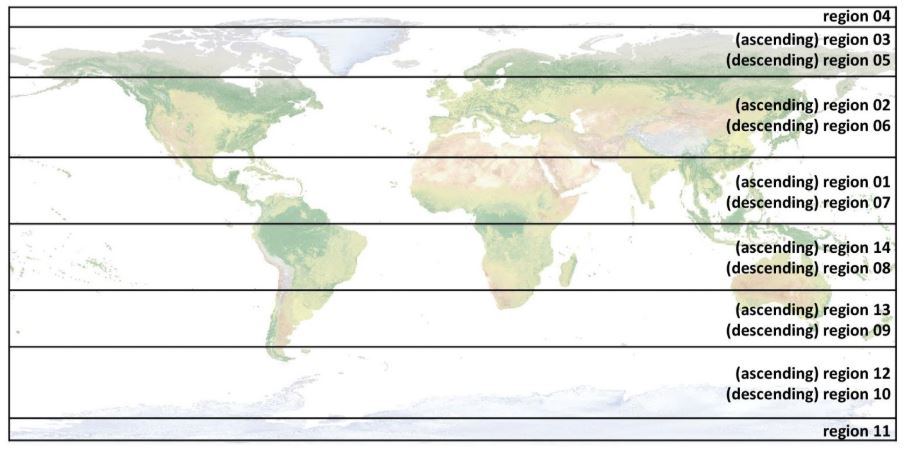

# Load files 
Files have already been downloaded from <a href = "https://search.earthdata.nasa.gov/" >NASA Earthdata Search </a>. 

Checking the structure of the ICESat-2 file. 

In [5]:
files = !ls data/bathymetry/*.h5
files

["ls: cannot access 'data/bathymetry/*.h5': No such file or directory"]

In [ ]:
!h5ls -r data/ATL03_20190323183114_13030205_002_01.h5

## Simple reader
This reader does the following: 
- Select variables of interest
- Filter data points based on quality flag and bbox
- Separate data into beams and ascending/descending tracks
- Saves data to a simpler HDF5 structure for redundancy and efficiency 

### Initial, utility functions

In [3]:
import pyproj
from astropy.time import Time 
import h5py
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
from itertools import chain
import sys

def list_files_local(path):
    ''' Get file list from local folder. '''
    from glob import glob
    return glob(path)

def gps2dyr(time):
    '''Convert GPS time to decimal years'''
    return Time(time, format='gps').decimalyear

def track_type(time, lat, tmax=1):
    '''
    Separate tracks into ascending and descending. 
    
    Defines tracks as segments with time breaks > tmax , 
    and tests whether lat increases or decreases w/time.
    '''
    tracks = np.zeros(lat.shape) # generates track segment
    tracks[0:np.argmax(np.abs(lat))] = 1 # set values for segment
    i_asc = np.zeros(tracks.shape, dtype=bool) # output index array 
    
    # loop through individual segments
    for track in np.unique(tracks):
        
        i_track, = np.where(track == tracks) # get all pts from seg
        
        if len(i_track) < 2: continue
            
        # Test if lat increase (asc) or descreases (des) with time
        i_min = time[i_track].argmin()
        i_max = time[i_track].argmax()
        lat_diff = lat[i_track][i_max] - lat[i_track][i_min]
        
        # Determine track trype
        if lat_diff > 0: i_asc[i_track] = True
            
    return i_asc, np.invert(i_asc)

def transform_coord(proj1, proj2, x, y):
    '''
    Transform coordinates from proj1 to proj2 (EPSG num). 
    
    Example EPSG projs: 
        Geodetic (lon/lat): 4326
        Polar Stereo AnIS (x/y): 3031
        Polar Stereo GrIS (x/y): 3413
    '''
    # Set full EPSG projection strings 
    proj1 = pyproj.Proj("+init=EPSG:"+str(proj1))
    proj2 = pyproj.Proj("+init=EPSG:"+str(proj2))
    return pyproj.transform(proj1, proj2, x, y)  # convert

def read_h5(fname, vnames=[]):
    '''Simple HDF5 reader'''
    with h5py.File(fname, 'r') as f:
        return [f[v][:] for v in vnames]
    

### The simple reader for extracting data

In [33]:
def read_data(fname, bbox=None):
    '''
    Read ATL03 data file and output 6 reduced files. 
    
    Extract variables of interest and separate the ATL03 file
    into each beam (ground track) and ascending/descending orbits. 
    '''
    
    # Each beam is a group 
    group = ['/gt1l', '/gt1r', '/gt2l', '/gt2r', '/gt3l', '/gt3r']
    
    # Loop through beams
    for k,g in enumerate(group):
    
        #-----------------------------------#
        # 1) Read in data for a single beam #
        #-----------------------------------#
    
        # Load variables into memory (more can be added!)
        with h5py.File(fname, 'r') as fi:
            sc = fi['/orbit_info/sc_orient'][:]
            
            #if sc == 1:
            #    g = ['/gt3r', '/gt3l', '/gtl2r', '/gt2l', '/gt1r', '/gt1l']   
                
            lat = fi[g+ '/heights/lat_ph'][:]
            lon = fi[g+ '/heights/lon_ph'][:]
            h_ph = fi[g+ '/heights/h_ph'][:]
            t_dt = fi[g+'/heights/delta_time'][:]
            t_ref = fi['/ancillary_data/atlas_sdp_gps_epoch'][:]
            geoid = fi[g+'/geophys_corr/geoid'][:]
            dac = fi[g+'/geophys_corr/dac'][:]
            ocean = fi[g+'/geophys_corr/tide_ocean'][:]
            signal_conf = fi[g+ '/heights/signal_conf_ph'][:, 2]
            signal_conf_ocean = fi[g+'/heights/signal_conf_ph'][:, 1]
            signal_conf_inland = fi[g+'/heights/signal_conf_ph'][:, 4]
            tide_load = fi[g+'/geophys_corr/tide_load'][:]
            ref_lat = fi[g+'/geolocation/reference_photon_lat'][:]
            ref_lon = fi[g+'/geolocation/reference_photon_lon'][:]
            bcr = fi[g+'/bckgrd_atlas/bckgrd_rate'][:]
            delta_t = fi[g+ '/bckgrd_atlas/delta_time'][:]
            
            #orb = np.full_like(h_ph, k)
            
        #---------------------------------------------#
        # 2) Filter data according region and quality #
        #---------------------------------------------#
        
        # Select a region of interest
        if bbox:
            lonmin, lonmax, latmin, latmax = bbox
            bbox_mask = (lon >= lonmin) & (lon <= lonmax) & \
                        (lat >= latmin) & (lat <= latmax)
            bbox_maskref = (ref_lon >= lonmin) & (ref_lon <= lonmax) & \
                           (ref_lat >= latmin) & (ref_lat <= latmax)
        else:
            bbox_mask = np.ones_like(lat, dtype=bool)  # get all
            bbox_maskref = np.ones_like(ref_lat, dtype=bool)
            
        # Only keep good data, and data inside bbox
        mask = (np.abs(h_ph) < 1e3) & (bbox_mask == 1) #& (signal_conf > 1)
        mask_ref = bbox_maskref == 1
        
        # Update variables
        lat, lon, h_ph, t_dt, signal_conf, signal_conf_ocean, signal_conf_inland = lat[mask], lon[mask], h_ph[mask], t_dt[mask], signal_conf[mask], signal_conf_ocean[mask], signal_conf_inland[mask]
        geoid, dac, ocean, ref_lat, ref_lon = geoid[mask_ref], dac[mask_ref], ocean[mask_ref], ref_lat[mask_ref], ref_lon[mask_ref]
        
        # Test for no data
        if len(h_ph) == 0: continue

        #-------------------------------------#
        # 3) Convert time and separate tracks #
        #-------------------------------------#
        
        # Time in GPS seconds (secs since 1980...)
        t_gps, delta_t_gps = t_ref + t_dt, t_ref + delta_t

        # Time in decimal years
        t_year, delta_t_year = gps2dyr(t_gps), gps2dyr(delta_t_gps)

        # Determine orbit type
        i_asc, i_des = track_type(t_year, lat)
        
        #-----------------------#
        # 4) Save selected data #
        #-----------------------#
        
        # Define output file name
        ofile = fname.replace('.h5', '_'+g[1:]+'.h5')
                
        # Save variables
        with h5py.File(ofile, 'w') as f:
            #f['orbit'] = orb
            f['lon'] = lon
            f['lat'] = lat
            f['h_elv'] = h_ph
            f['t_year'] = t_year
            f['geoid'] = geoid
            f['dac'] = dac
            f['ocean'] = ocean
            f['signal_conf'] = signal_conf
            f['signal_conf_ocean'] = signal_conf_ocean
            f['signal_conf_inland'] = signal_conf_inland
            f['ref_lat'] = ref_lat
            f['ref_lon'] = ref_lon
            f['bcr'] = bcr
            f['delta_t_year'] = delta_t_year

            print('out ->', ofile)

### Running the simple reader

In [176]:
njobs = 3

# bbox = [lonmin, lonmax, latmin, latmax]
bbox = None 

# Feasibility study (23E, 25.3E, 64.1N, 65.8N)
#bbox = [23, 25.3, 64.1, 65.8]

# Bay of Bothnia 
#bbox = [20.5, 25.5, 63.10, 66.10]

# Åland sea
#bbox = [10, 13, 56, 57.4]

if njobs == 1:
    print('running in serial ...')
    [read_data(f, bbox) for f in files]

else:
    print('running in parallel (%d jobs) ...' % njobs)
    from joblib import Parallel, delayed
    Parallel(n_jobs=njobs, verbose=5)(delayed(read_data)(f, bbox) for f in files)

running in parallel (3 jobs) ...


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   4 | elapsed:  2.4min remaining:  2.4min
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed:  2.9min finished


View the now extracted specific beam data. 

In [ ]:
!ls data/*.h5

In [ ]:
!h5ls -r data/ATL03_20190323183114_13030205_002_01_gt1l.h5

The code used so far has been adapted from the HackWeek Tutorials for ICESat-2, e.g.: https://github.com/ICESAT-2HackWeek/ICESat2_hackweek_tutorials/blob/master/07_SeaIce_Petty/Notebooks/1.%20ATL03.ipynb 

# Plot location of the track

C:\Users\renee\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app
C:\Users\renee\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


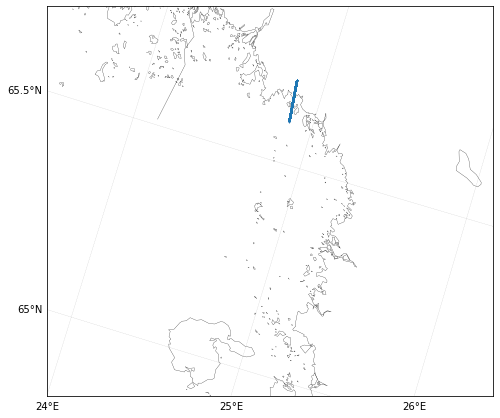

In [538]:
def load_plot_data2(files, axes, text):
    for fname in files:
        
        lon, lat = read_h5(fname, ['lon', 'lat'])
        
        latmin, latmax = [65.6, 65.7] # threshold if necessary (when investigating along-track photons)
        bbox_mask = (lat >= latmin) & (lat <= latmax)
        mask = (bbox_mask == 1)
        
        lat, lon, h2 = lat[mask], lon[mask], h[mask]
        
        m = Basemap(llcrnrlon=24,llcrnrlat=64.8,urcrnrlon=25.8,urcrnrlat=66,
                    projection='lcc', lat_1=24,lat_2=25.8,lon_0=65,
                    resolution ='h',area_thresh=0.)
        m.drawcoastlines(linewidth=0.25)
        m.drawcountries(linewidth=0.25)
        parallels = np.arange(-85.,85,0.5)
        meridians = np.arange(0.,360.,1)
        m.drawparallels(parallels,color="gray", linewidth=0.2, labels=[True,0,0,0])
        m.drawmeridians(meridians,color="gray", linewidth=0.2, labels=[0,0,0,True])

        m.plot(lon, lat, '.', latlon = True, c = 'tab:blue',  markersize = 0.5, alpha = 0.2)


fig = plt.figure(figsize=(8, 8))
ax3 = plt.subplot(111)
load_plot_data2(files2, ax3, '')

# Load already extracted beam-specific data for each specific study date

In [ ]:
'''
# Load data

# 20 january
lon_gt1l, lat_gt1l, t_gt1l, h_gt1l, sig_conf_gt1l, signal_conf_ocean_gt1l, signal_conf_inland_gt1l, geoid_gt1l, dac_gt1l, ref_lat_gt1l, ref_lon_gt1l, ocean_gt1l, bcr_gt1l, delta_t_gt1l = read_h5('D:/ICESat-2/data/january/ATL03_20190120212720_03580205_002_01_gt1l.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt1r, lat_gt1r, t_gt1r, h_gt1r, sig_conf_gt1r, signal_conf_ocean_gt1r, signal_conf_inland_gt1r, geoid_gt1r, dac_gt1r, ref_lat_gt1r, ref_lon_gt1r, ocean_gt1r, bcr_gt1r, delta_t_gt1r = read_h5('D:/ICESat-2/data/january/ATL03_20190120212720_03580205_002_01_gt1r.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt2l, lat_gt2l, t_gt2l, h_gt2l, sig_conf_gt2l, signal_conf_ocean_gt2l, signal_conf_inland_gt2l, geoid_gt2l, dac_gt2l, ref_lat_gt2l, ref_lon_gt2l, ocean_gt2l, bcr_gt2l, delta_t_gt2l = read_h5('D:/ICESat-2/data/january/ATL03_20190120212720_03580205_002_01_gt2l.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt2r, lat_gt2r, t_gt2r, h_gt2r, sig_conf_gt2r, signal_conf_ocean_gt2r, signal_conf_inland_gt2r, geoid_gt2r, dac_gt2r, ref_lat_gt2r, ref_lon_gt2r, ocean_gt2r, bcr_gt2r, delta_t_gt2r = read_h5('D:/ICESat-2/data/january/ATL03_20190120212720_03580205_002_01_gt2r.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt3l, lat_gt3l, t_gt3l, h_gt3l, sig_conf_gt3l, signal_conf_ocean_gt3l, signal_conf_inland_gt3l, geoid_gt3l, dac_gt3l, ref_lat_gt3l, ref_lon_gt3l, ocean_gt3l, bcr_gt3l, delta_t_gt3l = read_h5('D:/ICESat-2/data/january/ATL03_20190120212720_03580205_002_01_gt3l.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt3r, lat_gt3r, t_gt3r, h_gt3r, sig_conf_gt3r, signal_conf_ocean_gt3r, signal_conf_inland_gt3r, geoid_gt3r, dac_gt3r, ref_lat_gt3r, ref_lon_gt3r, ocean_gt3r, bcr_gt3r, delta_t_gt3r = read_h5('D:/ICESat-2/data/january/ATL03_20190120212720_03580205_002_01_gt3r.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])

# 28 january
lon_gt1l, lat_gt1l, t_gt1l, h_gt1l, sig_conf_gt1l, signal_conf_ocean_gt1l, signal_conf_inland_gt1l, geoid_gt1l, dac_gt1l, ref_lat_gt1l, ref_lon_gt1l, ocean_gt1l, bcr_gt1l, delta_t_gt1l = read_h5('D:/ICESat-2/data/january/ATL03_20190128211052_04800205_002_01_gt1l.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt1r, lat_gt1r, t_gt1r, h_gt1r, sig_conf_gt1r, signal_conf_ocean_gt1r, signal_conf_inland_gt1r, geoid_gt1r, dac_gt1r, ref_lat_gt1r, ref_lon_gt1r, ocean_gt1r, bcr_gt1r, delta_t_gt1r = read_h5('D:/ICESat-2/data/january/ATL03_20190128211052_04800205_002_01_gt1r.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt2l, lat_gt2l, t_gt2l, h_gt2l, sig_conf_gt2l, signal_conf_ocean_gt2l, signal_conf_inland_gt2l, geoid_gt2l, dac_gt2l, ref_lat_gt2l, ref_lon_gt2l, ocean_gt2l, bcr_gt2l, delta_t_gt2l = read_h5('D:/ICESat-2/data/january/ATL03_20190128211052_04800205_002_01_gt2l.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt2r, lat_gt2r, t_gt2r, h_gt2r, sig_conf_gt2r, signal_conf_ocean_gt2r, signal_conf_inland_gt2r, geoid_gt2r, dac_gt2r, ref_lat_gt2r, ref_lon_gt2r, ocean_gt2r, bcr_gt2r, delta_t_gt2r = read_h5('D:/ICESat-2/data/january/ATL03_20190128211052_04800205_002_01_gt2r.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt3l, lat_gt3l, t_gt3l, h_gt3l, sig_conf_gt3l, signal_conf_ocean_gt3l, signal_conf_inland_gt3l, geoid_gt3l, dac_gt3l, ref_lat_gt3l, ref_lon_gt3l, ocean_gt3l, bcr_gt3l, delta_t_gt3l = read_h5('D:/ICESat-2/data/january/ATL03_20190128211052_04800205_002_01_gt3l.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt3r, lat_gt3r, t_gt3r, h_gt3r, sig_conf_gt3r, signal_conf_ocean_gt3r, signal_conf_inland_gt3r, geoid_gt3r, dac_gt3r, ref_lat_gt3r, ref_lon_gt3r, ocean_gt3r, bcr_gt3r, delta_t_gt3r = read_h5('D:/ICESat-2/data/january/ATL03_20190128211052_04800205_002_01_gt3r.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])


# 23 march
lon_gt1l, lat_gt1l, t_gt1l, h_gt1l, sig_conf_gt1l, signal_conf_ocean_gt1l, signal_conf_inland_gt1l, geoid_gt1l, dac_gt1l, ref_lat_gt1l, ref_lon_gt1l, ocean_gt1l, bcr_gt1l, delta_t_gt1l = read_h5('D:/ICESat-2/data/ATL03_20190323183114_13030205_002_01_gt1l.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt1r, lat_gt1r, t_gt1r, h_gt1r, sig_conf_gt1r, signal_conf_ocean_gt1r, signal_conf_inland_gt1r, geoid_gt1r, dac_gt1r, ref_lat_gt1r, ref_lon_gt1r, ocean_gt1r, bcr_gt1r, delta_t_gt1r = read_h5('D:/ICESat-2/data/ATL03_20190323183114_13030205_002_01_gt1r.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt2l, lat_gt2l, t_gt2l, h_gt2l, sig_conf_gt2l, signal_conf_ocean_gt2l, signal_conf_inland_gt2l, geoid_gt2l, dac_gt2l, ref_lat_gt2l, ref_lon_gt2l, ocean_gt2l, bcr_gt2l, delta_t_gt2l = read_h5('D:/ICESat-2/data/ATL03_20190323183114_13030205_002_01_gt2l.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt2r, lat_gt2r, t_gt2r, h_gt2r, sig_conf_gt2r, signal_conf_ocean_gt2r, signal_conf_inland_gt2r, geoid_gt2r, dac_gt2r, ref_lat_gt2r, ref_lon_gt2r, ocean_gt2r, bcr_gt2r, delta_t_gt2r = read_h5('D:/ICESat-2/data/ATL03_20190323183114_13030205_002_01_gt2r.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt3l, lat_gt3l, t_gt3l, h_gt3l, sig_conf_gt3l, signal_conf_ocean_gt3l, signal_conf_inland_gt3l, geoid_gt3l, dac_gt3l, ref_lat_gt3l, ref_lon_gt3l, ocean_gt3l, bcr_gt3l, delta_t_gt3l = read_h5('D:/ICESat-2/data/ATL03_20190323183114_13030205_002_01_gt3l.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt3r, lat_gt3r, t_gt3r, h_gt3r, sig_conf_gt3r, signal_conf_ocean_gt3r, signal_conf_inland_gt3r, geoid_gt3r, dac_gt3r, ref_lat_gt3r, ref_lon_gt3r, ocean_gt3r, bcr_gt3r, delta_t_gt3r = read_h5('D:/ICESat-2/data/ATL03_20190323183114_13030205_002_01_gt3r.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])

# 27 march
lon_gt1l, lat_gt1l, t_gt1l, h_gt1l, sig_conf_gt1l, signal_conf_ocean_gt1l, signal_conf_inland_gt1l, geoid_gt1l, dac_gt1l, ref_lat_gt1l, ref_lon_gt1l, ocean_gt1l, bcr_gt1l, delta_t_gt1l = read_h5('D:/ICESat-2/data/march/ATL03_20190327182253_13640205_002_01_gt1l.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt1r, lat_gt1r, t_gt1r, h_gt1r, sig_conf_gt1r, signal_conf_ocean_gt1r, signal_conf_inland_gt1r, geoid_gt1r, dac_gt1r, ref_lat_gt1r, ref_lon_gt1r, ocean_gt1r, bcr_gt1r, delta_t_gt1r = read_h5('D:/ICESat-2/data/march/ATL03_20190327182253_13640205_002_01_gt1r.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt2l, lat_gt2l, t_gt2l, h_gt2l, sig_conf_gt2l, signal_conf_ocean_gt2l, signal_conf_inland_gt2l, geoid_gt2l, dac_gt2l, ref_lat_gt2l, ref_lon_gt2l, ocean_gt2l, bcr_gt2l, delta_t_gt2l = read_h5('D:/ICESat-2/data/march/ATL03_20190327182253_13640205_002_01_gt2l.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt2r, lat_gt2r, t_gt2r, h_gt2r, sig_conf_gt2r, signal_conf_ocean_gt2r, signal_conf_inland_gt2r, geoid_gt2r, dac_gt2r, ref_lat_gt2r, ref_lon_gt2r, ocean_gt2r, bcr_gt2r, delta_t_gt2r = read_h5('D:/ICESat-2/data/march/ATL03_20190327182253_13640205_002_01_gt2r.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt3l, lat_gt3l, t_gt3l, h_gt3l, sig_conf_gt3l, signal_conf_ocean_gt3l, signal_conf_inland_gt3l, geoid_gt3l, dac_gt3l, ref_lat_gt3l, ref_lon_gt3l, ocean_gt3l, bcr_gt3l, delta_t_gt3l = read_h5('D:/ICESat-2/data/march/ATL03_20190327182253_13640205_002_01_gt3l.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt3r, lat_gt3r, t_gt3r, h_gt3r, sig_conf_gt3r, signal_conf_ocean_gt3r, signal_conf_inland_gt3r, geoid_gt3r, dac_gt3r, ref_lat_gt3r, ref_lon_gt3r, ocean_gt3r, bcr_gt3r, delta_t_gt3r = read_h5('D:/ICESat-2/data/march/ATL03_20190327182253_13640205_002_01_gt3r.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])

# 01 February
lon_gt1l, lat_gt1l, t_gt1l, h_gt1l, sig_conf_gt1l, signal_conf_ocean_gt1l, signal_conf_inland_gt1l, geoid_gt1l, dac_gt1l, ref_lat_gt1l, ref_lon_gt1l, ocean_gt1l, bcr_gt1l, delta_t_gt1l = read_h5('D:/ICESat-2/data/february/ATL03_20190201210235_05410205_002_01_gt1l.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt1r, lat_gt1r, t_gt1r, h_gt1r, sig_conf_gt1r, signal_conf_ocean_gt1r, signal_conf_inland_gt1r, geoid_gt1r, dac_gt1r, ref_lat_gt1r, ref_lon_gt1r, ocean_gt1r, bcr_gt1r, delta_t_gt1r = read_h5('D:/ICESat-2/data/february/ATL03_20190201210235_05410205_002_01_gt1r.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt2l, lat_gt2l, t_gt2l, h_gt2l, sig_conf_gt2l, signal_conf_ocean_gt2l, signal_conf_inland_gt2l, geoid_gt2l, dac_gt2l, ref_lat_gt2l, ref_lon_gt2l, ocean_gt2l, bcr_gt2l, delta_t_gt2l = read_h5('D:/ICESat-2/data/february/ATL03_20190201210235_05410205_002_01_gt2l.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt2r, lat_gt2r, t_gt2r, h_gt2r, sig_conf_gt2r, signal_conf_ocean_gt2r, signal_conf_inland_gt2r, geoid_gt2r, dac_gt2r, ref_lat_gt2r, ref_lon_gt2r, ocean_gt2r, bcr_gt2r, delta_t_gt2r = read_h5('D:/ICESat-2/data/february/ATL03_20190201210235_05410205_002_01_gt2r.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt3l, lat_gt3l, t_gt3l, h_gt3l, sig_conf_gt3l, signal_conf_ocean_gt3l, signal_conf_inland_gt3l, geoid_gt3l, dac_gt3l, ref_lat_gt3l, ref_lon_gt3l, ocean_gt3l, bcr_gt3l, delta_t_gt3l = read_h5('D:/ICESat-2/data/february/ATL03_20190201210235_05410205_002_01_gt3l.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt3r, lat_gt3r, t_gt3r, h_gt3r, sig_conf_gt3r, signal_conf_ocean_gt3r, signal_conf_inland_gt3r, geoid_gt3r, dac_gt3r, ref_lat_gt3r, ref_lon_gt3r, ocean_gt3r, bcr_gt3r, delta_t_gt3r = read_h5('D:/ICESat-2/data/february/ATL03_20190201210235_05410205_002_01_gt3r.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])

# 17 February
lon_gt1l, lat_gt1l, t_gt1l, h_gt1l, sig_conf_gt1l, signal_conf_ocean_gt1l, signal_conf_inland_gt1l, geoid_gt1l, dac_gt1l, ref_lat_gt1l, ref_lon_gt1l, ocean_gt1l, bcr_gt1l, delta_t_gt1l = read_h5('D:/ICESat-2/data/february/ATL03_20190217074419_07770203_002_01_gt1l.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt1r, lat_gt1r, t_gt1r, h_gt1r, sig_conf_gt1r, signal_conf_ocean_gt1r, signal_conf_inland_gt1r, geoid_gt1r, dac_gt1r, ref_lat_gt1r, ref_lon_gt1r, ocean_gt1r, bcr_gt1r, delta_t_gt1r = read_h5('D:/ICESat-2/data/february/ATL03_20190217074419_07770203_002_01_gt1r.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt2l, lat_gt2l, t_gt2l, h_gt2l, sig_conf_gt2l, signal_conf_ocean_gt2l, signal_conf_inland_gt2l, geoid_gt2l, dac_gt2l, ref_lat_gt2l, ref_lon_gt2l, ocean_gt2l, bcr_gt2l, delta_t_gt2l = read_h5('D:/ICESat-2/data/february/ATL03_20190217074419_07770203_002_01_gt2l.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt2r, lat_gt2r, t_gt2r, h_gt2r, sig_conf_gt2r, signal_conf_ocean_gt2r, signal_conf_inland_gt2r, geoid_gt2r, dac_gt2r, ref_lat_gt2r, ref_lon_gt2r, ocean_gt2r, bcr_gt2r, delta_t_gt2r = read_h5('D:/ICESat-2/data/february/ATL03_20190217074419_07770203_002_01_gt2r.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt3l, lat_gt3l, t_gt3l, h_gt3l, sig_conf_gt3l, signal_conf_ocean_gt3l, signal_conf_inland_gt3l, geoid_gt3l, dac_gt3l, ref_lat_gt3l, ref_lon_gt3l, ocean_gt3l, bcr_gt3l, delta_t_gt3l = read_h5('D:/ICESat-2/data/february/ATL03_20190217074419_07770203_002_01_gt3l.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt3r, lat_gt3r, t_gt3r, h_gt3r, sig_conf_gt3r, signal_conf_ocean_gt3r, signal_conf_inland_gt3r, geoid_gt3r, dac_gt3r, ref_lat_gt3r, ref_lon_gt3r, ocean_gt3r, bcr_gt3r, delta_t_gt3r = read_h5('D:/ICESat-2/data/february/ATL03_20190217074419_07770203_002_01_gt3r.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])

# 05 February
lon_gt1l, lat_gt1l, t_gt1l, h_gt1l, sig_conf_gt1l, signal_conf_ocean_gt1l, signal_conf_inland_gt1l, geoid_gt1l, dac_gt1l, ref_lat_gt1l, ref_lon_gt1l, ocean_gt1l, bcr_gt1l, delta_t_gt1l = read_h5('D:/ICESat-2/data/february/ATL03_20190205080922_05940203_002_01_gt1l.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt1r, lat_gt1r, t_gt1r, h_gt1r, sig_conf_gt1r, signal_conf_ocean_gt1r, signal_conf_inland_gt1r, geoid_gt1r, dac_gt1r, ref_lat_gt1r, ref_lon_gt1r, ocean_gt1r, bcr_gt1r, delta_t_gt1r = read_h5('D:/ICESat-2/data/february/ATL03_20190205080922_05940203_002_01_gt1r.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt2l, lat_gt2l, t_gt2l, h_gt2l, sig_conf_gt2l, signal_conf_ocean_gt2l, signal_conf_inland_gt2l, geoid_gt2l, dac_gt2l, ref_lat_gt2l, ref_lon_gt2l, ocean_gt2l, bcr_gt2l, delta_t_gt2l = read_h5('D:/ICESat-2/data/february/ATL03_20190205080922_05940203_002_01_gt2l.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt2r, lat_gt2r, t_gt2r, h_gt2r, sig_conf_gt2r, signal_conf_ocean_gt2r, signal_conf_inland_gt2r, geoid_gt2r, dac_gt2r, ref_lat_gt2r, ref_lon_gt2r, ocean_gt2r, bcr_gt2r, delta_t_gt2r = read_h5('D:/ICESat-2/data/february/ATL03_20190205080922_05940203_002_01_gt2r.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt3l, lat_gt3l, t_gt3l, h_gt3l, sig_conf_gt3l, signal_conf_ocean_gt3l, signal_conf_inland_gt3l, geoid_gt3l, dac_gt3l, ref_lat_gt3l, ref_lon_gt3l, ocean_gt3l, bcr_gt3l, delta_t_gt3l = read_h5('D:/ICESat-2/data/february/ATL03_20190205080922_05940203_002_01_gt3l.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt3r, lat_gt3r, t_gt3r, h_gt3r, sig_conf_gt3r, signal_conf_ocean_gt3r, signal_conf_inland_gt3r, geoid_gt3r, dac_gt3r, ref_lat_gt3r, ref_lon_gt3r, ocean_gt3r, bcr_gt3r, delta_t_gt3r = read_h5('D:/ICESat-2/data/february/ATL03_20190205080922_05940203_002_01_gt3r.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])

# 22 February
lon_gt1l, lat_gt1l, t_gt1l, h_gt1l, sig_conf_gt1l, signal_conf_ocean_gt1l, signal_conf_inland_gt1l, geoid_gt1l, dac_gt1l, ref_lat_gt1l, ref_lon_gt1l, ocean_gt1l, bcr_gt1l, delta_t_gt1l = read_h5('D:/ICESat-2/data/february/ATL03_20190221073558_08380203_002_01_gt1l.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt1r, lat_gt1r, t_gt1r, h_gt1r, sig_conf_gt1r, signal_conf_ocean_gt1r, signal_conf_inland_gt1r, geoid_gt1r, dac_gt1r, ref_lat_gt1r, ref_lon_gt1r, ocean_gt1r, bcr_gt1r, delta_t_gt1r = read_h5('D:/ICESat-2/data/february/ATL03_20190221073558_08380203_002_01_gt1r.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt2l, lat_gt2l, t_gt2l, h_gt2l, sig_conf_gt2l, signal_conf_ocean_gt2l, signal_conf_inland_gt2l, geoid_gt2l, dac_gt2l, ref_lat_gt2l, ref_lon_gt2l, ocean_gt2l, bcr_gt2l, delta_t_gt2l = read_h5('D:/ICESat-2/data/february/ATL03_20190221073558_08380203_002_01_gt2l.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt2r, lat_gt2r, t_gt2r, h_gt2r, sig_conf_gt2r, signal_conf_ocean_gt2r, signal_conf_inland_gt2r, geoid_gt2r, dac_gt2r, ref_lat_gt2r, ref_lon_gt2r, ocean_gt2r, bcr_gt2r, delta_t_gt2r = read_h5('D:/ICESat-2/data/february/ATL03_20190221073558_08380203_002_01_gt2r.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt3l, lat_gt3l, t_gt3l, h_gt3l, sig_conf_gt3l, signal_conf_ocean_gt3l, signal_conf_inland_gt3l, geoid_gt3l, dac_gt3l, ref_lat_gt3l, ref_lon_gt3l, ocean_gt3l, bcr_gt3l, delta_t_gt3l = read_h5('D:/ICESat-2/data/february/ATL03_20190221073558_08380203_002_01_gt3l.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt3r, lat_gt3r, t_gt3r, h_gt3r, sig_conf_gt3r, signal_conf_ocean_gt3r, signal_conf_inland_gt3r, geoid_gt3r, dac_gt3r, ref_lat_gt3r, ref_lon_gt3r, ocean_gt3r, bcr_gt3r, delta_t_gt3r = read_h5('D:/ICESat-2/data/february/ATL03_20190221073558_08380203_002_01_gt3r.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])


'''

# Load data

# 27 march
lon_gt1l, lat_gt1l, t_gt1l, h_gt1l, sig_conf_gt1l, signal_conf_ocean_gt1l, signal_conf_inland_gt1l, geoid_gt1l, dac_gt1l, ref_lat_gt1l, ref_lon_gt1l, ocean_gt1l, bcr_gt1l, delta_t_gt1l = read_h5('D:/ICESat-2/data/march/ATL03_20190327182253_13640205_002_01_gt1l.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt1r, lat_gt1r, t_gt1r, h_gt1r, sig_conf_gt1r, signal_conf_ocean_gt1r, signal_conf_inland_gt1r, geoid_gt1r, dac_gt1r, ref_lat_gt1r, ref_lon_gt1r, ocean_gt1r, bcr_gt1r, delta_t_gt1r = read_h5('D:/ICESat-2/data/march/ATL03_20190327182253_13640205_002_01_gt1r.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt2l, lat_gt2l, t_gt2l, h_gt2l, sig_conf_gt2l, signal_conf_ocean_gt2l, signal_conf_inland_gt2l, geoid_gt2l, dac_gt2l, ref_lat_gt2l, ref_lon_gt2l, ocean_gt2l, bcr_gt2l, delta_t_gt2l = read_h5('D:/ICESat-2/data/march/ATL03_20190327182253_13640205_002_01_gt2l.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt2r, lat_gt2r, t_gt2r, h_gt2r, sig_conf_gt2r, signal_conf_ocean_gt2r, signal_conf_inland_gt2r, geoid_gt2r, dac_gt2r, ref_lat_gt2r, ref_lon_gt2r, ocean_gt2r, bcr_gt2r, delta_t_gt2r = read_h5('D:/ICESat-2/data/march/ATL03_20190327182253_13640205_002_01_gt2r.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt3l, lat_gt3l, t_gt3l, h_gt3l, sig_conf_gt3l, signal_conf_ocean_gt3l, signal_conf_inland_gt3l, geoid_gt3l, dac_gt3l, ref_lat_gt3l, ref_lon_gt3l, ocean_gt3l, bcr_gt3l, delta_t_gt3l = read_h5('D:/ICESat-2/data/march/ATL03_20190327182253_13640205_002_01_gt3l.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])
lon_gt3r, lat_gt3r, t_gt3r, h_gt3r, sig_conf_gt3r, signal_conf_ocean_gt3r, signal_conf_inland_gt3r, geoid_gt3r, dac_gt3r, ref_lat_gt3r, ref_lon_gt3r, ocean_gt3r, bcr_gt3r, delta_t_gt3r = read_h5('D:/ICESat-2/data/march/ATL03_20190327182253_13640205_002_01_gt3r.h5', ['lon', 'lat', 't_year', 'h_elv', 'signal_conf', 'signal_conf_ocean', 'signal_conf_inland', 'geoid', 'dac', 'ref_lat', 'ref_lon', 'ocean', 'bcr', 'delta_t_year'])



### Masking of geoid fill values 
As geoid parameter have a fill value of 3.4028235E38, this must be masked out in both geoid, dac, ocean and reference latitude and longitude in able to use it for correcting the ellipsoidal heights by segments. Thus, a general threshold of 1000m is applied. 

In [ ]:
def mask_geoid(geoid, lat, lon, ocean, dac):
    mask = (geoid < 1e3) & (ocean < 1e3) & (dac < 1e3)
    geoid, lat, lon, ocean, dac = geoid[mask], lat[mask], lon[mask], ocean[mask], dac[mask]
    return geoid, lat, lon, ocean, dac

print(len(geoid_gt1l))

geoid_gt1l, ref_lat_gt1l, ref_lon_gt1l, ocean_gt1l, dac_gt1l = mask_geoid(geoid_gt1l, ref_lat_gt1l, ref_lon_gt1l, ocean_gt1l, dac_gt1l)
geoid_gt1r, ref_lat_gt1r, ref_lon_gt1r, ocean_gt1r, dac_gt1r = mask_geoid(geoid_gt1r, ref_lat_gt1r, ref_lon_gt1r, ocean_gt1r, dac_gt1r)
geoid_gt2l, ref_lat_gt2l, ref_lon_gt2l, ocean_gt2l, dac_gt2l = mask_geoid(geoid_gt2l, ref_lat_gt2l, ref_lon_gt2l, ocean_gt2l, dac_gt2l)
geoid_gt2r, ref_lat_gt2r, ref_lon_gt2r, ocean_gt2r, dac_gt2r = mask_geoid(geoid_gt2r, ref_lat_gt2r, ref_lon_gt2r, ocean_gt2r, dac_gt2r)
geoid_gt3l, ref_lat_gt3l, ref_lon_gt3l, ocean_gt3l, dac_gt3l = mask_geoid(geoid_gt3l, ref_lat_gt3l, ref_lon_gt3l, ocean_gt3l, dac_gt3l)
geoid_gt3r, ref_lat_gt3r, ref_lon_gt3r, ocean_gt3r, dac_gt3r = mask_geoid(geoid_gt3r, ref_lat_gt3r, ref_lon_gt3r, ocean_gt3r, dac_gt3r)

print(len(geoid_gt1l))

corr_gt1l = geoid_gt1l + ocean_gt1l + dac_gt1l
corr_gt1r = geoid_gt1r + ocean_gt1r + dac_gt1r
corr_gt2l = geoid_gt2l + ocean_gt2l + dac_gt2l
corr_gt2r = geoid_gt2r + ocean_gt2r + dac_gt2r
corr_gt3l = geoid_gt3l + ocean_gt3l + dac_gt3l
corr_gt3r = geoid_gt3r + ocean_gt3r + dac_gt3r

df_geo_corr_gt1l = pd.DataFrame({'geoid':geoid_gt1l, 'ocean':ocean_gt1l, 'dac':dac_gt1l})
df_geo_corr_gt1r = pd.DataFrame({'geoid':geoid_gt1r, 'ocean':ocean_gt1r, 'dac':dac_gt1r})
df_geo_corr_gt2l = pd.DataFrame({'geoid':geoid_gt2l, 'ocean':ocean_gt2l, 'dac':dac_gt2l})
df_geo_corr_gt2r = pd.DataFrame({'geoid':geoid_gt2r, 'ocean':ocean_gt2r, 'dac':dac_gt2r})
df_geo_corr_gt3l = pd.DataFrame({'geoid':geoid_gt3l, 'ocean':ocean_gt3l, 'dac':dac_gt3l})
df_geo_corr_gt3r = pd.DataFrame({'geoid':geoid_gt3r, 'ocean':ocean_gt3r, 'dac':dac_gt3r})

frames = [df_geo_corr_gt1l,df_geo_corr_gt1r,df_geo_corr_gt2l,df_geo_corr_gt2r,df_geo_corr_gt3l,df_geo_corr_gt3r ]
df_geo_corr = pd.concat(frames)

path = 'D:/ICESat-2/'
text2 = '27mar2019'
text4 = '.csv'

df_geo_corr.to_csv(path+"geo_corr_"+text2+text4, sep=",")


### Apply mask of only high-signal confidence photons
This flag could already have been applied when extracting/formatting the data (to beam-specific data), although since we also investigated the distribution of the signal confidence flags (not included in the study), we had to mask them later on.

In [ ]:
def mask(lat, lon, h, sign, t):
    mask_high = sign == 4
    lat_masked, lon_masked, h_masked, sign_masked, t_masked = lat[mask_high], lon[mask_high], h[mask_high], sign[mask_high], t[mask_high]
    return lat_masked, lon_masked, h_masked, sign_masked, t_masked


m_lat_gt1l, m_lon_gt1l, m_h_gt1l, m_sig_conf_gt1l, m_t_gt1l = mask(lat_gt1l, lon_gt1l, h_gt1l, sig_conf_gt1l, t_gt1l)
m_lat_gt1r, m_lon_gt1r, m_h_gt1r, m_sig_conf_gt1r, m_t_gt1r = mask(lat_gt1r, lon_gt1r, h_gt1r, sig_conf_gt1r, t_gt1r)
m_lat_gt2l, m_lon_gt2l, m_h_gt2l, m_sig_conf_gt2l, m_t_gt2l = mask(lat_gt2l, lon_gt2l, h_gt2l, sig_conf_gt2l, t_gt2l)
m_lat_gt2r, m_lon_gt2r, m_h_gt2r, m_sig_conf_gt2r, m_t_gt2r = mask(lat_gt2r, lon_gt2r, h_gt2r, sig_conf_gt2r, t_gt2r)
m_lat_gt3l, m_lon_gt3l, m_h_gt3l, m_sig_conf_gt3l, m_t_gt3l = mask(lat_gt3l, lon_gt3l, h_gt3l, sig_conf_gt3l, t_gt3l)
m_lat_gt3r, m_lon_gt3r, m_h_gt3r, m_sig_conf_gt3r, m_t_gt3r = mask(lat_gt3r, lon_gt3r, h_gt3r, sig_conf_gt3r, t_gt3r)


# Study area focus
Use this to minimize dataset to only relevant data (Bay of Bothnia data) for both the geophysical corrections and the photons.

C:\Users\renee\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


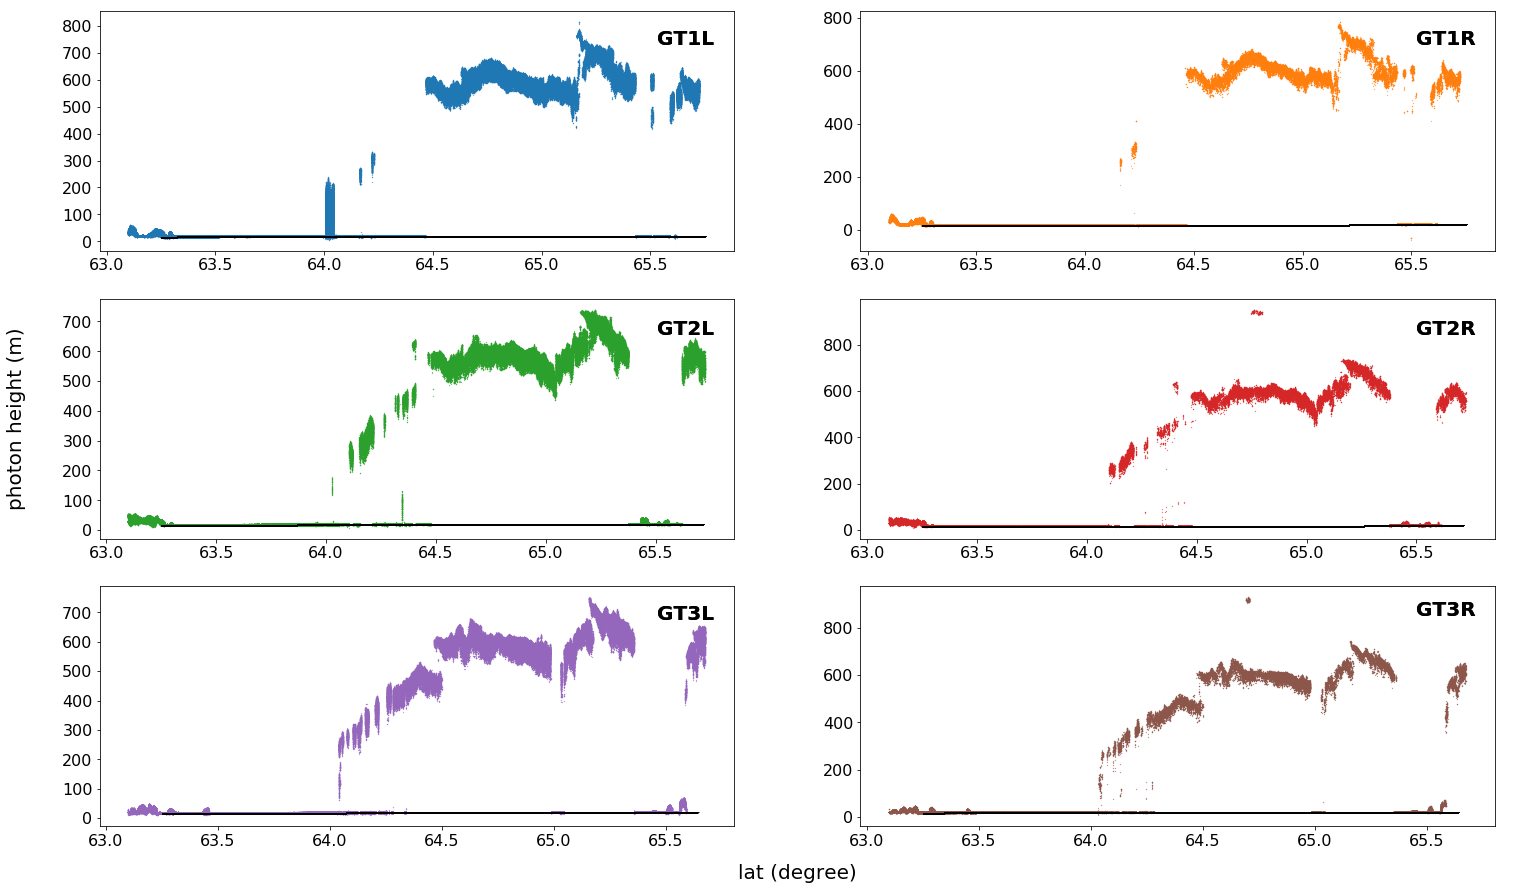

In [8]:
import pandas as pd

def mask_bbox(lat, lon, h, sign, bbox, t):
    lonmin, lonmax, latmin, latmax = bbox
    bbox_mask = (lon >= lonmin) & (lon <= lonmax) & \
                (lat >= latmin) & (lat <= latmax)

    lat_masked, lon_masked, h_masked, sign_masked, t_masked = lat[bbox_mask], lon[bbox_mask], h[bbox_mask], sign[bbox_mask], t[bbox_mask]
    return lat_masked, lon_masked, h_masked, sign_masked, t_masked

def mask_bbox2(lat, lon, geoid, bbox):
    lonmin, lonmax, latmin, latmax = bbox
    bbox_mask = (lon >= lonmin) & (lon <= lonmax) & \
                (lat >= latmin) & (lat <= latmax)
    
    lat, lon, geoid = lat[bbox_mask], lon[bbox_mask], geoid[bbox_mask]
    return lat, lon, geoid


bbox = [20.0, 27, 63., 66.] 
mb_lat_gt1l, mb_lon_gt1l, mb_h_gt1l, mb_sig_conf_gt1l, mb_t_gt1l = mask_bbox(m_lat_gt1l, m_lon_gt1l, m_h_gt1l, m_sig_conf_gt1l, bbox, m_t_gt1l)
mb_lat_gt1r, mb_lon_gt1r, mb_h_gt1r, mb_sig_conf_gt1r, mb_t_gt1r = mask_bbox(m_lat_gt1r, m_lon_gt1r, m_h_gt1r, m_sig_conf_gt1r, bbox, m_t_gt1r)
mb_lat_gt2l, mb_lon_gt2l, mb_h_gt2l, mb_sig_conf_gt2l, mb_t_gt2l = mask_bbox(m_lat_gt2l, m_lon_gt2l, m_h_gt2l, m_sig_conf_gt2l, bbox, m_t_gt2l)
mb_lat_gt2r, mb_lon_gt2r, mb_h_gt2r, mb_sig_conf_gt2r, mb_t_gt2r = mask_bbox(m_lat_gt2r, m_lon_gt2r, m_h_gt2r, m_sig_conf_gt2r, bbox, m_t_gt2r)
mb_lat_gt3l, mb_lon_gt3l, mb_h_gt3l, mb_sig_conf_gt3l, mb_t_gt3l = mask_bbox(m_lat_gt3l, m_lon_gt3l, m_h_gt3l, m_sig_conf_gt3l, bbox, m_t_gt3l)
mb_lat_gt3r, mb_lon_gt3r, mb_h_gt3r, mb_sig_conf_gt3r, mb_t_gt3r = mask_bbox(m_lat_gt3r, m_lon_gt3r, m_h_gt3r, m_sig_conf_gt3r, bbox, m_t_gt3r)

m_ref_lat_gt1l, m_ref_lon_gt1l, m_corr_gt1l = mask_bbox2(ref_lat_gt1l, ref_lon_gt1l, corr_gt1l, bbox)
m_ref_lat_gt1r, m_ref_lon_gt1r, m_corr_gt1r = mask_bbox2(ref_lat_gt1r, ref_lon_gt1r, corr_gt1r, bbox)
m_ref_lat_gt2l, m_ref_lon_gt2l, m_corr_gt2l = mask_bbox2(ref_lat_gt2l, ref_lon_gt2l, corr_gt2l, bbox)
m_ref_lat_gt2r, m_ref_lon_gt2r, m_corr_gt2r = mask_bbox2(ref_lat_gt2r, ref_lon_gt2r, corr_gt2r, bbox)
m_ref_lat_gt3l, m_ref_lon_gt3l, m_corr_gt3l = mask_bbox2(ref_lat_gt3l, ref_lon_gt3l, corr_gt3l, bbox)
m_ref_lat_gt3r, m_ref_lon_gt3r, m_corr_gt3r = mask_bbox2(ref_lat_gt3r, ref_lon_gt3r, corr_gt3r, bbox)


fig = plt.figure(figsize=(25,15))
rows = 3
columns = 2
ax = fig.add_subplot(111) 

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

plot_data(fig, rows, columns, 1, mb_lat_gt1l, mb_h_gt1l, '.', 0.5, 'tab:blue', 'GT1L', ax, 0.42, 0.965)
plot_data(fig, rows, columns, 1, m_ref_lat_gt1l, m_corr_gt1l, '+', 1, 'black', 'GT1L', ax, 0.42, 0.965)
plot_data(fig, rows, columns, 2, mb_lat_gt1r, mb_h_gt1r, '.', 0.5, 'tab:orange', 'GT1R', ax, 0.965, 0.965)
plot_data(fig, rows, columns, 2, m_ref_lat_gt1r, m_corr_gt1r, '+', 1, 'black', 'GT1R', ax, 0.965, 0.965)
plot_data(fig, rows, columns, 3, mb_lat_gt2l, mb_h_gt2l, '.', 0.5, 'tab:green', 'GT2L', ax, 0.42, 0.61)
plot_data(fig, rows, columns, 3, m_ref_lat_gt2l, m_corr_gt2l, '+', 1, 'black', 'GT2L', ax, 0.42, 0.61)
plot_data(fig, rows, columns, 4, mb_lat_gt2r, mb_h_gt2r, '.', 0.5, 'tab:red', 'GT2R', ax, 0.965, 0.61)
plot_data(fig, rows, columns, 4, m_ref_lat_gt2r, m_corr_gt2r, '+', 1, 'black', 'GT2R', ax, 0.965, 0.61)
plot_data(fig, rows, columns, 5, mb_lat_gt3l, mb_h_gt3l, '.', 0.5, 'tab:purple', 'GT3L', ax, 0.42, 0.26)
plot_data(fig, rows, columns, 5, m_ref_lat_gt3l, m_corr_gt3l, '+', 1, 'black', 'GT3L', ax, 0.42, 0.26)
plot_data(fig, rows, columns, 6, mb_lat_gt3r, mb_h_gt3r, '.', 0.5, 'tab:brown', 'GT3R', ax, 0.965, 0.265)
plot_data(fig, rows, columns, 6, m_ref_lat_gt3r, m_corr_gt3r, '+', 1, 'black', 'GT3R', ax, 0.965, 0.265)

ax.set_xlabel('lat (degree)', fontsize='20')
ax.set_ylabel('photon height (m)', fontsize='20')
ax.tick_params(axis='x', which='major', pad=20)
ax.tick_params(axis='y', which='major', pad=50)


### Mean sea surface (geoid, DAC and ocean tide corrections)
The photon heights have been corrected for several delays, but is still the WGS84 ellipsoidal heights. Thus, it has yet to be corrected for the geoid, dynamic atmosphere (DAC) or the ocean tide. 

We have imported the 20m segmented geoid, DAC and ocean tide corrections from the ICESat-2 data and added them up, and shown as the black line in the plot above. The combined corrections are given at every 20m referred to a reference photon with a given `ref_lat` and `ref_lon`. The corrections are applied by polynominally fitting the 20m separated corrections.

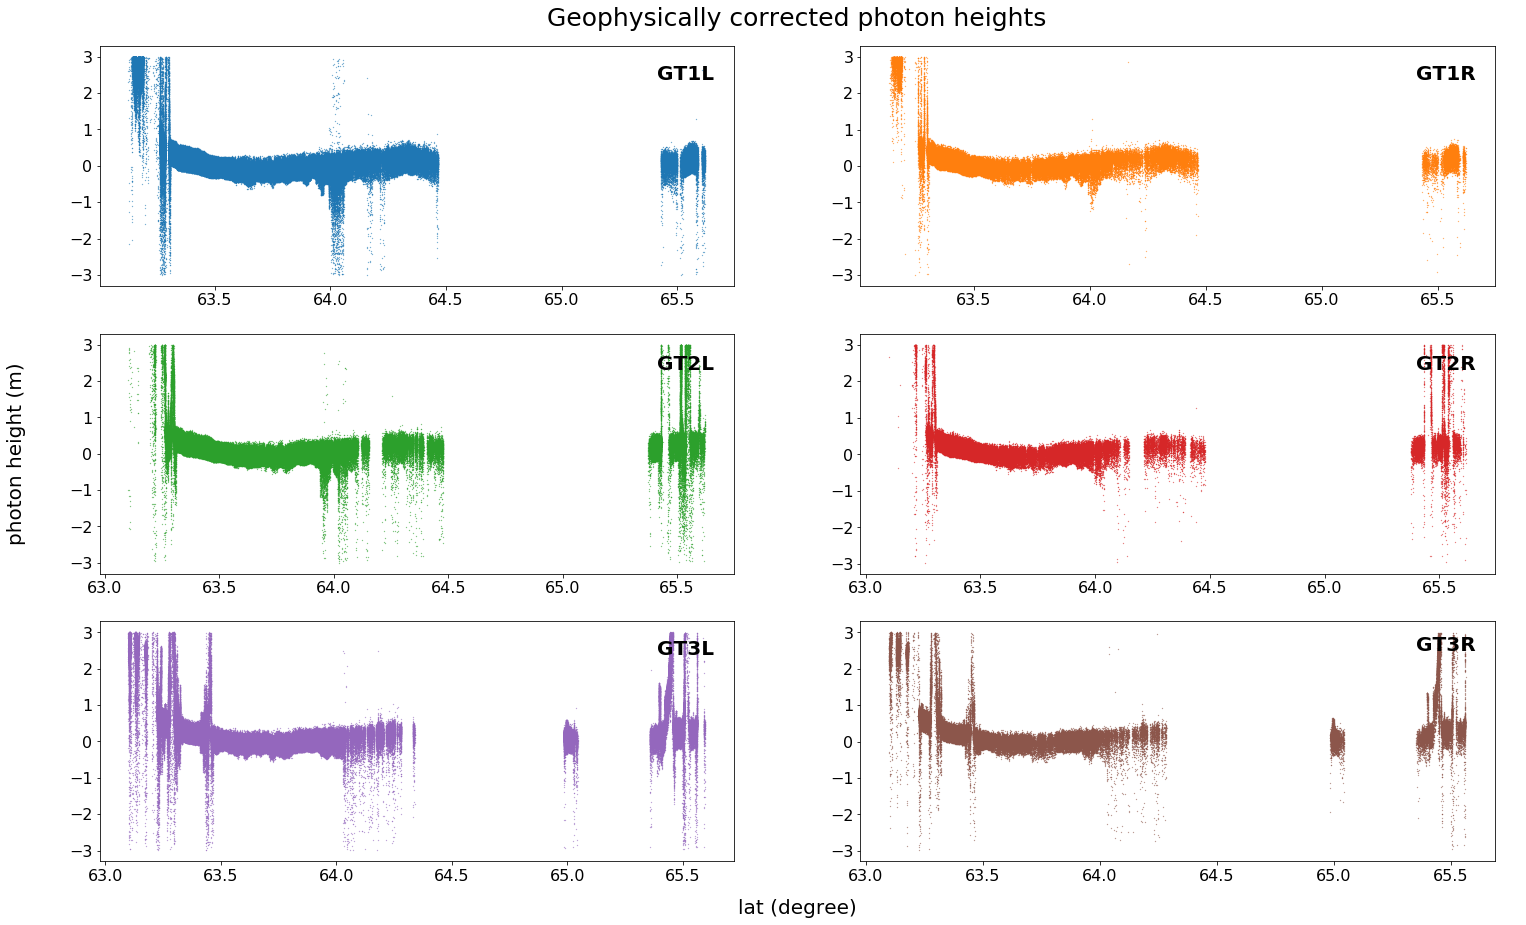

In [9]:
def fit2(lat, lat2,  h, degree):
    p_fit = np.polyfit(lat, h, degree)
    p_val = np.polyval(p_fit, lat2)
    return p_val

f_gt1l = fit2(m_ref_lat_gt1l, mb_lat_gt1l, m_corr_gt1l, 3)
h_f_gt1l = mb_h_gt1l- f_gt1l

f_gt1r = fit2(m_ref_lat_gt1r, mb_lat_gt1r, m_corr_gt1r, 3)
h_f_gt1r = mb_h_gt1r- f_gt1r

f_gt2l = fit2(m_ref_lat_gt2l, mb_lat_gt2l, m_corr_gt2l, 3)
h_f_gt2l = mb_h_gt2l- f_gt2l

f_gt2r = fit2(m_ref_lat_gt2r, mb_lat_gt2r, m_corr_gt2r, 3)
h_f_gt2r = mb_h_gt2r- f_gt2r

f_gt3l = fit2(m_ref_lat_gt3l, mb_lat_gt3l, m_corr_gt3l, 3)
h_f_gt3l = mb_h_gt3l- f_gt3l

f_gt3r = fit2(m_ref_lat_gt3r, mb_lat_gt3r, m_corr_gt3r, 3)
h_f_gt3r = mb_h_gt3r- f_gt3r

df_gt1l = pd.DataFrame({'lat':mb_lat_gt1l, 'h':h_f_gt1l, 'lon':mb_lon_gt1l})
df_gt1r = pd.DataFrame({'lat':mb_lat_gt1r, 'h':h_f_gt1r, 'lon':mb_lon_gt1r})
df_gt2l = pd.DataFrame({'lat':mb_lat_gt2l, 'h':h_f_gt2l, 'lon':mb_lon_gt2l})
df_gt2r = pd.DataFrame({'lat':mb_lat_gt2r, 'h':h_f_gt2r, 'lon':mb_lon_gt2r})
df_gt3l = pd.DataFrame({'lat':mb_lat_gt3l, 'h':h_f_gt3l, 'lon':mb_lon_gt3l})
df_gt3r = pd.DataFrame({'lat':mb_lat_gt3r, 'h':h_f_gt3r, 'lon':mb_lon_gt3r})

## MSS filtration (+- 3 m from MSS as sea ice is only here)

df_gt1l = df_gt1l[abs(df_gt1l['h'])<3]
df_gt1r = df_gt1r[abs(df_gt1r['h'])<3]
df_gt2l = df_gt2l[abs(df_gt2l['h'])<3]
df_gt2r = df_gt2r[abs(df_gt2r['h'])<3]
df_gt3l = df_gt3l[abs(df_gt3l['h'])<3]
df_gt3r = df_gt3r[abs(df_gt3r['h'])<3]

fig = plt.figure(figsize=(25,15))
rows = 3
columns = 2
ax = fig.add_subplot(111) 

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_title('Geophysically corrected photon heights', fontsize='25', pad = 20)
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
plot_data(fig, rows, columns, 1, df_gt1l['lat'], df_gt1l['h'], '.', 0.5, 'tab:blue', 'GT1L', ax, 0.42, 0.965)
plot_data(fig, rows, columns, 2, df_gt1r['lat'], df_gt1r['h'], '.', 0.5, 'tab:orange', 'GT1R', ax, 0.965, 0.965)
plot_data(fig, rows, columns, 3, df_gt2l['lat'], df_gt2l['h'], '.', 0.5, 'tab:green', 'GT2L', ax, 0.42, 0.61)
plot_data(fig, rows, columns, 4, df_gt2r['lat'], df_gt2r['h'], '.', 0.5, 'tab:red', 'GT2R', ax, 0.965, 0.61)
plot_data(fig, rows, columns, 5, df_gt3l['lat'], df_gt3l['h'], '.', 0.5, 'tab:purple', 'GT3L', ax, 0.42, 0.26)
plot_data(fig, rows, columns, 6, df_gt3r['lat'], df_gt3r['h'], '.', 0.5, 'tab:brown', 'GT3R', ax, 0.965, 0.265)

ax.set_xlabel('lat (degree)', fontsize='20')
ax.set_ylabel('photon height (m)', fontsize='20')
ax.tick_params(axis='x', which='major', pad=20)
ax.tick_params(axis='y', which='major', pad=50)

lat_corr_gt1l, h_corr_gt1l, lon_corr_gt1l = df_gt1l['lat'].dropna().to_numpy(), df_gt1l['h'].dropna().to_numpy(), df_gt1l['lon'].dropna().to_numpy()
lat_corr_gt1r, h_corr_gt1r, lon_corr_gt1r = df_gt1r['lat'].dropna().to_numpy(), df_gt1r['h'].dropna().to_numpy(), df_gt1r['lon'].dropna().to_numpy()
lat_corr_gt2l, h_corr_gt2l, lon_corr_gt2l = df_gt2l['lat'].dropna().to_numpy(), df_gt2l['h'].dropna().to_numpy(), df_gt2l['lon'].dropna().to_numpy()
lat_corr_gt2r, h_corr_gt2r, lon_corr_gt2r = df_gt2r['lat'].dropna().to_numpy(), df_gt2r['h'].dropna().to_numpy(), df_gt2r['lon'].dropna().to_numpy()
lat_corr_gt3l, h_corr_gt3l, lon_corr_gt3l = df_gt3l['lat'].dropna().to_numpy(), df_gt3l['h'].dropna().to_numpy(), df_gt3l['lon'].dropna().to_numpy()
lat_corr_gt3r, h_corr_gt3r, lon_corr_gt3r = df_gt3r['lat'].dropna().to_numpy(), df_gt3r['h'].dropna().to_numpy(), df_gt3r['lon'].dropna().to_numpy()

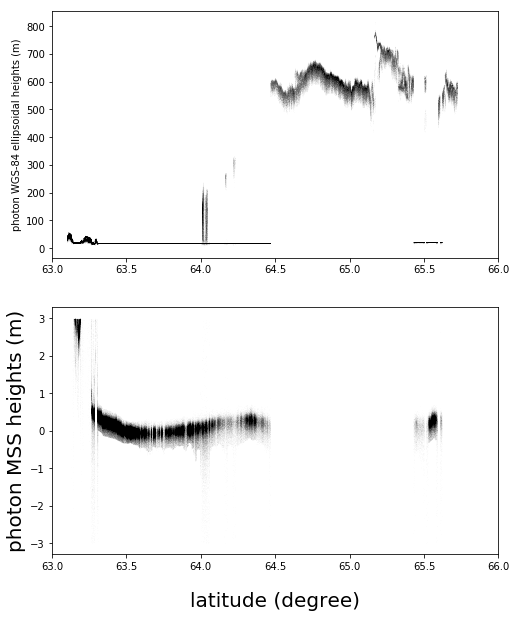

In [39]:
fig = plt.figure(figsize=(8,10))
rows = 2
columns = 1
ax = fig.add_subplot(111) 

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

fig.add_subplot(2, 1, 1)
plt.plot(mb_lat_gt1l, mb_h_gt1l, '.', markersize  = 0.1, color = 'k', alpha = 0.05)
plt.ylabel('photon WGS-84 ellipsoidal heights (m)')
plt.xlim(63.0, 66.0)
fig.add_subplot(2, 1, 2)
plt.plot(df_gt1l['lat'], df_gt1l['h'], '.', markersize  = 0.1, color = 'k', alpha = 0.05)
plt.xlim(63.0, 66.0)
plt.ylabel('photon MSS heights (m)', fontsize = 20)

ax.set_xlabel('latitude (degree)', fontsize='20')
#ax.set_ylabel('photon height (m)', fontsize='20')
ax.tick_params(axis='x', which='major', pad=20)
#ax.tick_params(axis='y', which='major', pad=50)

# Finnish Ice Service (FIS) Ice charts
Below find initial loading of the data and a plot to show the contour lines of the DIR zones.

C:\Users\renee\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\renee\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


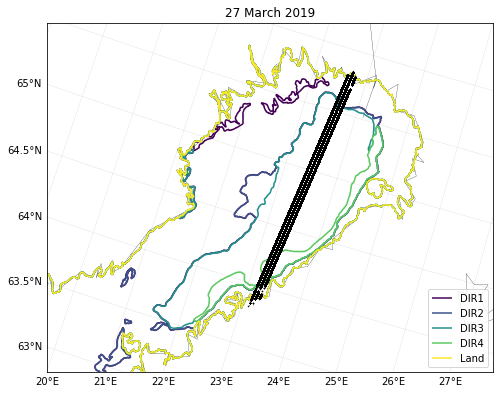

In [8]:
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
from itertools import chain
import sys

text = '27 March 2019'

root_chart = Dataset('D:/ICESat-2/charts/20190327140000_icechart.nc', 'r')
root_chart.variables.keys()
lat_DIR = root_chart.variables['lat'][:]
lon_DIR = root_chart.variables['lon'][:]
DIR = root_chart.variables['kFmiIceDegreeOfRidging'][:]
np.shape(lat_DIR)
np.shape(lon_DIR)
np.shape(DIR)
lat2 = np.array(lat_DIR.data[:])
lon2 = np.array(lon_DIR.data[:])
data2 = np.array(DIR.data[0, :, :])
DIR_mask = DIR.mask[:]
n_lat = (np.shape(lat2))
n_lon = (np.shape(lon2))

for i in list(range(0,(3120-1))):
    for j in list(range(0,(2640-1))):
        if DIR_mask[0,i, j] is True:
            data2[i, j] = np.nan
        

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
m = Basemap(llcrnrlon=20.,llcrnrlat=62.8,urcrnrlon=26.,urcrnrlat=66.5,
            projection='lcc', lat_1=22.,lat_2=27,lon_0=64.5,
            resolution ='l',area_thresh=1000.)
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)

parallels = np.arange(-85.,85,0.5)
meridians = np.arange(0.,360.,1)
m.drawparallels(parallels,color="gray", linewidth=0.2, labels=[True,0,0,0])
m.drawmeridians(meridians,color="gray", linewidth=0.2, labels=[0,0,0,True])

xx, yy = np.meshgrid(lon2, lat2)

cs = m.contour(xx,yy, data2, latlon = True, levels = [0,1,2,3,4])
#m.colorbar()


labels = ['DIR1', 'DIR2', 'DIR3', 'DIR4','Land']
for i in range(len(labels)):
    cs.collections[i].set_label(labels[i])

leg1 = plt.legend(loc='lower right')


#leg1 = plt.legend(loc='lower right')


m.plot(lon_corr_gt1l, lat_corr_gt1l, '.', latlon = True, c = 'k',  markersize = 0.2, alpha = 0.2)
m.plot(lon_corr_gt1r, lat_corr_gt1r, '.', latlon = True, c = 'k', markersize = 0.2, alpha = 0.2)
m.plot(lon_corr_gt2l, lat_corr_gt2l, '.', latlon = True, c = 'k', markersize = 0.2, alpha = 0.2)
m.plot(lon_corr_gt2r, lat_corr_gt2r, '.', latlon = True, c = 'k', markersize = 0.2, alpha = 0.2)
m.plot(lon_corr_gt3l, lat_corr_gt3l, '.', latlon = True, c = 'k', markersize = 0.2, alpha = 0.2)
m.plot(lon_corr_gt3r, lat_corr_gt3r, '.', latlon = True, c = 'k', markersize = 0.2, alpha = 0.2)

'''
fig.text(0.26, 0.81, '23 March 2019', horizontalalignment='center',verticalalignment='center', fontsize = '16')
'''
plt.title(text)
plt.show()

# Geophysical corrections masked to specific area that corresponds to the region of the track that fits with the specific DIR

In [ ]:
def mask_bbox_chart(lat, lon, h, bbox):
    lonmin, lonmax, latmin, latmax = bbox
    bbox_mask = (lon >= lonmin) & (lon <= lonmax) & \
                (lat >= latmin) & (lat <= latmax)

    lat_masked, lon_masked, h_masked = lat[bbox_mask], lon[bbox_mask], h[bbox_mask]
    return lat_masked, lon_masked, h_masked

#bbox = [21, 25, 63.95, 64.15] # DIR1, 17 Feb 2019
#bbox = [21, 25, 64.95, 65.15] # DIR1, 17 Feb 2019

#bbox = [21, 23, 63.6, 63.9] # DIR1, 01 Feb 2019

#bbox = [23.9, 24.5, 64.7, 64.9] # DIR2, 23.03.2019

#bbox = [23.2, 23.8, 64.5, 65.5] # DIR2, 27.03.2019
#bbox = [23.1, 23.5, 64.1, 64.2] # DIR3, 27.03.2019

#bbox = [21, 26, 65.3, 65.35] #  20 January 2019
#bbox = [21, 26, 63.56, 63.74] #  21 February 2019


bbox = [20.0, 25, 63., 68.] # total bothnian bay 

text_title = '23 March 2019'
text2 = '01022019' + '_non_correct'
text3 = '_totalbay.csv'
n = 150


DIR2_lat_gt1l, DIR2_lon_gt1l, DIR2_h_gt1l = mask_bbox_chart(lat_corr_gt1l, lon_corr_gt1l, h_corr_gt1l, bbox)
DIR2_lat_gt1r, DIR2_lon_gt1r, DIR2_h_gt1r = mask_bbox_chart(lat_corr_gt1r, lon_corr_gt1r, h_corr_gt1r, bbox)
DIR2_lat_gt2l, DIR2_lon_gt2l, DIR2_h_gt2l = mask_bbox_chart(lat_corr_gt2l, lon_corr_gt2l, h_corr_gt2l, bbox)
DIR2_lat_gt2r, DIR2_lon_gt2r, DIR2_h_gt2r = mask_bbox_chart(lat_corr_gt2r, lon_corr_gt2r, h_corr_gt2r, bbox)
DIR2_lat_gt3l, DIR2_lon_gt3l, DIR2_h_gt3l = mask_bbox_chart(lat_corr_gt3l, lon_corr_gt3l, h_corr_gt3l, bbox)
DIR2_lat_gt3r, DIR2_lon_gt3r, DIR2_h_gt3r = mask_bbox_chart(lat_corr_gt3r, lon_corr_gt3r, h_corr_gt3r, bbox)

df_gt1l_corr = pd.DataFrame({'lat':DIR2_lat_gt1l, 'lon': DIR2_lon_gt1l, 'h':DIR2_h_gt1l})
df_gt1r_corr = pd.DataFrame({'lat':DIR2_lat_gt1r, 'lon': DIR2_lon_gt1r, 'h':DIR2_h_gt1r})
df_gt2l_corr = pd.DataFrame({'lat':DIR2_lat_gt2l, 'lon': DIR2_lon_gt2l, 'h':DIR2_h_gt2l})
df_gt2r_corr = pd.DataFrame({'lat':DIR2_lat_gt2r, 'lon': DIR2_lon_gt2r, 'h':DIR2_h_gt2r})
df_gt3l_corr = pd.DataFrame({'lat':DIR2_lat_gt3l, 'lon': DIR2_lon_gt3l, 'h':DIR2_h_gt3l})
df_gt3r_corr = pd.DataFrame({'lat':DIR2_lat_gt3r, 'lon': DIR2_lon_gt3r, 'h':DIR2_h_gt3r})

df_gt1l_corr.to_csv("corr_gt1l_"+text2+text3, sep=",")
df_gt1r_corr.to_csv("corr_gt1r_"+text2+text3, sep=",")
df_gt2l_corr.to_csv("corr_gt2l_"+text2+text3, sep=",")
df_gt2r_corr.to_csv("corr_gt2r_"+text2+text3, sep=",")
df_gt3l_corr.to_csv("corr_gt3l_"+text2+text3, sep=",")
df_gt3r_corr.to_csv("corr_gt3r_"+text2+text3, sep=",")

# Loading of DIR and ice types from FIS ice charts

In [4]:
def icechart_load(fileaname):
    root_chart = Dataset(filename, 'r')
    root_chart.variables.keys()
    lat_DIR = root_chart.variables['lat'][:]
    lon_DIR = root_chart.variables['lon'][:]
    DIR = root_chart.variables['kFmiIceDegreeOfRidging'][:]
    np.shape(lat_DIR)
    np.shape(lon_DIR)
    np.shape(DIR)
    lat2 = np.array(lat_DIR.data[:])
    lon2 = np.array(lon_DIR.data[:])
    data2 = np.array(DIR.data[0, :, :])
    DIR_mask = DIR.mask[:]
    n_lat = (np.shape(lat2))
    n_lon = (np.shape(lon2))

    for i in list(range(0,(3120-1))):
        for j in list(range(0,(2640-1))):
            if DIR_mask[0,i, j] is True:
                data2[i, j] = np.nan
    return data2, lat2, lon2


filename = 'D:/ICESat-2/charts/20190327140000_icechart.nc'
data_27032019, lat_27032019, lon_27032019 = icechart_load(filename)
filename = 'D:/ICESat-2/charts/20190323140000_icechart.nc'
data_23032019, lat_23032019, lon_23032019 = icechart_load(filename)
filename = 'D:/ICESat-2/charts/20190217140000_icechart.nc'
data_17022019, lat_17022019, lon_17022019 = icechart_load(filename)
filename = 'D:/ICESat-2/charts/20190201140000_icechart.nc'
data_01022019, lat_01022019, lon_01022019 = icechart_load(filename)



In [9]:
def icechart_load_2(fileaname):
    root_chart = Dataset(filename, 'r')
    root_chart.variables.keys()
    lat_DIR = root_chart.variables['lat'][:]
    lon_DIR = root_chart.variables['lon'][:]
    DIR = root_chart.variables['kFmiIceType'][:]
    np.shape(lat_DIR)
    np.shape(lon_DIR)
    np.shape(DIR)
    lat2 = np.array(lat_DIR.data[:])
    lon2 = np.array(lon_DIR.data[:])
    data2 = np.array(DIR.data[0, :, :])
    DIR_mask = DIR.mask[:]
    n_lat = (np.shape(lat2))
    n_lon = (np.shape(lon2))

    for i in list(range(0,(3120-1))):
        for j in list(range(0,(2640-1))):
            if DIR_mask[0,i, j] is True:
                data2[i, j] = np.nan
    
        #for i in list(range(0,(3120-1))):
        #    for j in list(range(0,(2640-1))):
        #        if data2[i, j] != 8:
        #            data2[i, j] = np.nan
                
    return data2, lat2, lon2

filename = 'D:/ICESat-2/charts/20190327140000_icechart.nc'
data2_27032019, lat2_27032019, lon2_27032019 = icechart_load_2(filename)
filename = 'D:/ICESat-2/charts/20190323140000_icechart.nc'
data2_23032019, lat2_23032019, lon2_23032019 = icechart_load_2(filename)
filename = 'D:/ICESat-2/charts/20190217140000_icechart.nc'
data2_17022019, lat2_17022019, lon2_17022019 = icechart_load_2(filename)
filename = 'D:/ICESat-2/charts/20190201140000_icechart.nc'
data2_01022019, lat2_01022019, lon2_01022019 = icechart_load_2(filename)

# Loading corrected data (either DIR zone dependent or entire track)

In [44]:
'''
df_gt1l_corr = pd.read_csv('D:/ICESat-2/corr_gt1l_1feb2019_non_correct.csv')
df_gt1r_corr = pd.read_csv('D:/ICESat-2/corr_gt1r_1feb2019_non_correct.csv')
df_gt2l_corr = pd.read_csv('D:/ICESat-2/corr_gt2l_1feb2019_non_correct.csv')
df_gt2r_corr = pd.read_csv('D:/ICESat-2/corr_gt2r_1feb2019_non_correct.csv')
df_gt3l_corr = pd.read_csv('D:/ICESat-2/corr_gt3l_1feb2019_non_correct.csv')
df_gt3r_corr = pd.read_csv('D:/ICESat-2/corr_gt3r_1feb2019_non_correct.csv')
text2 = '1feb2019_non_correct'
'''
'''
df_gt1l_corr = pd.read_csv('D:/ICESat-2/corr_gt1l_17feb2019_non_correct.csv')
df_gt1r_corr = pd.read_csv('D:/ICESat-2/corr_gt1r_17feb2019_non_correct.csv')
df_gt2l_corr = pd.read_csv('D:/ICESat-2/corr_gt2l_17feb2019_non_correct.csv')
df_gt2r_corr = pd.read_csv('D:/ICESat-2/corr_gt2r_17feb2019_non_correct.csv')
df_gt3l_corr = pd.read_csv('D:/ICESat-2/corr_gt3l_17feb2019_non_correct.csv')
df_gt3r_corr = pd.read_csv('D:/ICESat-2/corr_gt3r_17feb2019_non_correct.csv')
text2 = '17feb2019_non_correct'
'''
'''
df_gt1l_corr = pd.read_csv('D:/ICESat-2/corr_gt1l_17feb2019_2_non_correct.csv')
df_gt1r_corr = pd.read_csv('D:/ICESat-2/corr_gt1r_17feb2019_2_non_correct.csv')
df_gt2l_corr = pd.read_csv('D:/ICESat-2/corr_gt2l_17feb2019_2_non_correct.csv')
df_gt2r_corr = pd.read_csv('D:/ICESat-2/corr_gt2r_17feb2019_2_non_correct.csv')
df_gt3l_corr = pd.read_csv('D:/ICESat-2/corr_gt3l_17feb2019_2_non_correct.csv')
df_gt3r_corr = pd.read_csv('D:/ICESat-2/corr_gt3r_17feb2019_2_non_correct.csv')
text2 = '17feb2019_2_non_correct'
'''
'''
df_gt1l_corr = pd.read_csv('D:/ICESat-2/corr_gt1l_23032019_DIR2_non_correct.csv')
df_gt1r_corr = pd.read_csv('D:/ICESat-2/corr_gt1r_23032019_DIR2_non_correct.csv')
df_gt2l_corr = pd.read_csv('D:/ICESat-2/corr_gt2l_23032019_DIR2_non_correct.csv')
df_gt2r_corr = pd.read_csv('D:/ICESat-2/corr_gt2r_23032019_DIR2_non_correct.csv')
df_gt3l_corr = pd.read_csv('D:/ICESat-2/corr_gt3l_23032019_DIR2_non_correct.csv')
df_gt3r_corr = pd.read_csv('D:/ICESat-2/corr_gt3r_23032019_DIR2_non_correct.csv')
text2 = '23032019_DIR2_non_correct'
'''
'''
df_gt1l_corr = pd.read_csv('D:/ICESat-2/corr_gt1l_27032019_DIR2_non_correct.csv')
df_gt1r_corr = pd.read_csv('D:/ICESat-2/corr_gt1r_27032019_DIR2_non_correct.csv')
df_gt2l_corr = pd.read_csv('D:/ICESat-2/corr_gt2l_27032019_DIR2_non_correct.csv')
df_gt2r_corr = pd.read_csv('D:/ICESat-2/corr_gt2r_27032019_DIR2_non_correct.csv')
df_gt3l_corr = pd.read_csv('D:/ICESat-2/corr_gt3l_27032019_DIR2_non_correct.csv')
df_gt3r_corr = pd.read_csv('D:/ICESat-2/corr_gt3r_27032019_DIR2_non_correct.csv')
text2 = '27032019_DIR2_non_correct'
'''
'''
df_gt1l_corr = pd.read_csv('D:/ICESat-2/corr_gt1l_27032019_DIR3_non_correct.csv')
df_gt1r_corr = pd.read_csv('D:/ICESat-2/corr_gt1r_27032019_DIR3_non_correct.csv')
df_gt2l_corr = pd.read_csv('D:/ICESat-2/corr_gt2l_27032019_DIR3_non_correct.csv')
df_gt2r_corr = pd.read_csv('D:/ICESat-2/corr_gt2r_27032019_DIR3_non_correct.csv')
df_gt3l_corr = pd.read_csv('D:/ICESat-2/corr_gt3l_27032019_DIR3_non_correct.csv')
df_gt3r_corr = pd.read_csv('D:/ICESat-2/corr_gt3r_27032019_DIR3_non_correct.csv')
text2 = '27032019_DIR3_non_correct'
'''
'''
df_gt1l_corr = pd.read_csv('D:/ICESat-2/corr_gt1l_27032019_non_correct_totalbay.csv')
df_gt1r_corr = pd.read_csv('D:/ICESat-2/corr_gt1r_27032019_non_correct_totalbay.csv')
df_gt2l_corr = pd.read_csv('D:/ICESat-2/corr_gt2l_27032019_non_correct_totalbay.csv')
df_gt2r_corr = pd.read_csv('D:/ICESat-2/corr_gt2r_27032019_non_correct_totalbay.csv')
df_gt3l_corr = pd.read_csv('D:/ICESat-2/corr_gt3l_27032019_non_correct_totalbay.csv')
df_gt3r_corr = pd.read_csv('D:/ICESat-2/corr_gt3r_27032019_non_correct_totalbay.csv')
text2 = '27032019_non_correct'
'''
'''
df_gt1l_corr = pd.read_csv('D:/ICESat-2/corr_gt1l_23032019_non_correct_totalbay.csv')
df_gt1r_corr = pd.read_csv('D:/ICESat-2/corr_gt1r_23032019_non_correct_totalbay.csv')
df_gt2l_corr = pd.read_csv('D:/ICESat-2/corr_gt2l_23032019_non_correct_totalbay.csv')
df_gt2r_corr = pd.read_csv('D:/ICESat-2/corr_gt2r_23032019_non_correct_totalbay.csv')
df_gt3l_corr = pd.read_csv('D:/ICESat-2/corr_gt3l_23032019_non_correct_totalbay.csv')
df_gt3r_corr = pd.read_csv('D:/ICESat-2/corr_gt3r_23032019_non_correct_totalbay.csv')
text2 = "23032019_non_correct"
'''
'''
df_gt1l_corr = pd.read_csv('D:/ICESat-2/corr_gt1l_17022019_non_correct_totalbay.csv')
df_gt1r_corr = pd.read_csv('D:/ICESat-2/corr_gt1r_17022019_non_correct_totalbay.csv')
df_gt2l_corr = pd.read_csv('D:/ICESat-2/corr_gt2l_17022019_non_correct_totalbay.csv')
df_gt2r_corr = pd.read_csv('D:/ICESat-2/corr_gt2r_17022019_non_correct_totalbay.csv')
df_gt3l_corr = pd.read_csv('D:/ICESat-2/corr_gt3l_17022019_non_correct_totalbay.csv')
df_gt3r_corr = pd.read_csv('D:/ICESat-2/corr_gt3r_17022019_non_correct_totalbay.csv')
text2 = '17022019_non_correct'
'''
#'''
df_gt1l_corr = pd.read_csv('D:/ICESat-2/corr_gt1l_01022019_non_correct_totalbay.csv')
df_gt1r_corr = pd.read_csv('D:/ICESat-2/corr_gt1r_01022019_non_correct_totalbay.csv')
df_gt2l_corr = pd.read_csv('D:/ICESat-2/corr_gt2l_01022019_non_correct_totalbay.csv')
df_gt2r_corr = pd.read_csv('D:/ICESat-2/corr_gt2r_01022019_non_correct_totalbay.csv')
df_gt3l_corr = pd.read_csv('D:/ICESat-2/corr_gt3l_01022019_non_correct_totalbay.csv')
df_gt3r_corr = pd.read_csv('D:/ICESat-2/corr_gt3r_01022019_non_correct_totalbay.csv')
text2 = '01022019_non_correct'
#'''

# Calculate segments of 150 photons (surface anomaly)

In [45]:
from scipy import stats

def calc_high_mean(df, n):
    # init
    value, lat, lon, list_per98, = [], [], [], []
    
    # extract data
    df_lat, df_lon, df_h = np.array(df['lat'].dropna()), np.array(df['lon'].dropna()), np.array(df['h'].dropna())
    
    #calculate value max-mean within photon segment of n values
    for i in range(0, len(df_h)-1, n):
        # calculate as long as there are 150 photons available
        if i < len(df_h)-(n+1):
            track, track_lat, track_lon = df_h[i:i+n], df_lat[i:i+n], df_lon[i:i+n]
            value = np.append(value, np.max(track)-np.mean(track))
            list_per98 = np.append(list_per98, np.percentile(track-np.mean(track), 98))
            lat = np.append(lat, np.mean(track_lat))
            lon = np.append(lon, np.mean(track_lon))
        elif i > len(track)-(n+1):
            break
    # save data to new dataframe 
    df = pd.DataFrame({'lat':lat, 'lon': lon, 'h':value,'per98':list_per98})
    return df 

N = 150
df_gt1l_calc = calc_high_mean(df_gt1l_corr, N)
df_gt1r_calc = calc_high_mean(df_gt1r_corr, N)
df_gt2l_calc = calc_high_mean(df_gt2l_corr, N)
df_gt2r_calc = calc_high_mean(df_gt2r_corr, N)
df_gt3l_calc = calc_high_mean(df_gt3l_corr, N)
df_gt3r_calc = calc_high_mean(df_gt3r_corr, N)

path = 'D:/ICESat-2/'
text4 = '.csv'

df_gt1l_calc.to_csv(path+"calc_gt1l_"+text2+text4, sep=",")
df_gt1r_calc.to_csv(path+"calc_gt1r_"+text2+text4, sep=",")
df_gt2l_calc.to_csv(path+"calc_gt2l_"+text2+text4, sep=",")
df_gt2r_calc.to_csv(path+"calc_gt2r_"+text2+text4, sep=",")
df_gt3l_calc.to_csv(path+"calc_gt3l_"+text2+text4, sep=",")
df_gt3r_calc.to_csv(path+"calc_gt3r_"+text2+text4, sep=",")

# Categorise DIR from chosen DIR intervals

In [200]:
def DIR_calc(df):
    value, lat, lon = [], [], []
    
    DIR2 = np.array([0.38, 0.48])
    DIR3 = np.array([0.48, 0.60])
    DIR4 = np.array([0.60, 0.75])

    
    df_h = np.array(df['h'].dropna()) 
    df_lat, df_lon = np.array(df['lat'].dropna()), np.array(df['lon'].dropna())
    for i in range(0, len(df_h)):
        #if df_h[i] < DIR2[0]:
        #    value = np.append(value, 1)
        if df_h[i] > DIR2[0] and df_h[i] <= DIR2[1]:
            value = np.append(value, 2)
            lat = np.append(lat, df_lat[i])
            lon = np.append(lon, df_lon[i])
        elif df_h[i] > DIR3[0] and df_h[i] <= DIR3[1]:
            value = np.append(value, 3)
            lat = np.append(lat, df_lat[i])
            lon = np.append(lon, df_lon[i])
        elif df_h[i] > DIR4[0] and df_h[i] <= DIR4[1]:
            value = np.append(value, 4)
            lat = np.append(lat, df_lat[i])
            lon = np.append(lon, df_lon[i])
        #elif df_h[i] > DIR4[1] :
        #    value = np.append(value, 5)
    
    df = pd.DataFrame({'lat':lat, 'lon': lon, 'cat':value})
    
    return df

df_result_gt1l = DIR_calc(df_gt1l_calc)
df_result_gt1r = DIR_calc(df_gt1r_calc)
df_result_gt2l = DIR_calc(df_gt2l_calc)
df_result_gt2r = DIR_calc(df_gt2r_calc)
df_result_gt3l = DIR_calc(df_gt3l_calc)
df_result_gt3r = DIR_calc(df_gt3r_calc)

text3 = ''
text4 = '.csv'
path = 'D:/ICESat-2/'

df_result_gt1l.to_csv(path+"res_gt1l_"+text2+text3+text4, sep=",")
df_result_gt1r.to_csv(path+"res_gt1r_"+text2+text3+text4, sep=",")
df_result_gt2l.to_csv(path+"res_gt2l_"+text2+text3+text4, sep=",")
df_result_gt2r.to_csv(path+"res_gt2r_"+text2+text3+text4, sep=",")
df_result_gt3l.to_csv(path+"res_gt3l_"+text2+text3+text4, sep=",")
df_result_gt3r.to_csv(path+"res_gt3r_"+text2+text3+text4, sep=",")

# Estimate ridge density by accumulating 300 surface anomalies into one strip (counts above 0.4 m cut-off height)

In [46]:
def DIR_calc(df, n):
    value, lat, lon, res_count = [], [], [], []
    df_h = np.array(df['h'].dropna()) # max-mean
    df_lat, df_lon = np.array(df['lat'].dropna()), np.array(df['lon'].dropna())
    for i in range(0, len(df_h)-1, n):
        # calculate as long as there are 150 photons available
        if i < len(df_h)-(n+1):
            track, track_lat, track_lon = df_h[i:i+n], df_lat[i:i+n], df_lon[i:i+n]
            count = 0
            for i in range(0, len(track)-1):
                if track[i] > 0.4: 
                    count = count+1
                    value = np.append(value, track[i])
            lat = np.append(lat, np.mean(track_lat))
            lon = np.append(lon, np.mean(track_lon))
            res_count = np.append(res_count, count)
            
    
    df = pd.DataFrame({'lat':lat, 'lon': lon, 'cat':res_count})
    df1 = pd.DataFrame({'elev_40cm':value})
    
    return df, df1

n = 300
df_result_gt1l, df_above_gt1l = DIR_calc(df_gt1l_calc, n)
df_result_gt1r, df_above_gt1r = DIR_calc(df_gt1r_calc, n)
df_result_gt2l, df_above_gt2l = DIR_calc(df_gt2l_calc, n)
df_result_gt2r, df_above_gt2r = DIR_calc(df_gt2r_calc, n)
df_result_gt3l, df_above_gt3l = DIR_calc(df_gt3l_calc, n)
df_result_gt3r, df_above_gt3r = DIR_calc(df_gt3r_calc, n)

text3 = ''
text4 = '.csv'
path = 'D:/ICESat-2/'

df_result_gt1l.to_csv(path+"res3_gt1l_"+text2+text3+text4, sep=",")
df_result_gt1r.to_csv(path+"res3_gt1r_"+text2+text3+text4, sep=",")
df_result_gt2l.to_csv(path+"res3_gt2l_"+text2+text3+text4, sep=",")
df_result_gt2r.to_csv(path+"res3_gt2r_"+text2+text3+text4, sep=",")
df_result_gt3l.to_csv(path+"res3_gt3l_"+text2+text3+text4, sep=",")
df_result_gt3r.to_csv(path+"res3_gt3r_"+text2+text3+text4, sep=",")

df_above_gt1l.to_csv(path+"res4_gt1l_"+text2+text3+text4, sep=",")
df_above_gt1r.to_csv(path+"res4_gt1r_"+text2+text3+text4, sep=",")
df_above_gt2l.to_csv(path+"res4_gt2l_"+text2+text3+text4, sep=",")
df_above_gt2r.to_csv(path+"res4_gt2r_"+text2+text3+text4, sep=",")
df_above_gt3l.to_csv(path+"res4_gt3l_"+text2+text3+text4, sep=",")
df_above_gt3r.to_csv(path+"res4_gt3r_"+text2+text3+text4, sep=",")

# Plot data of DIR based on amplitude (ridge sails)

C:\Users\renee\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\renee\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


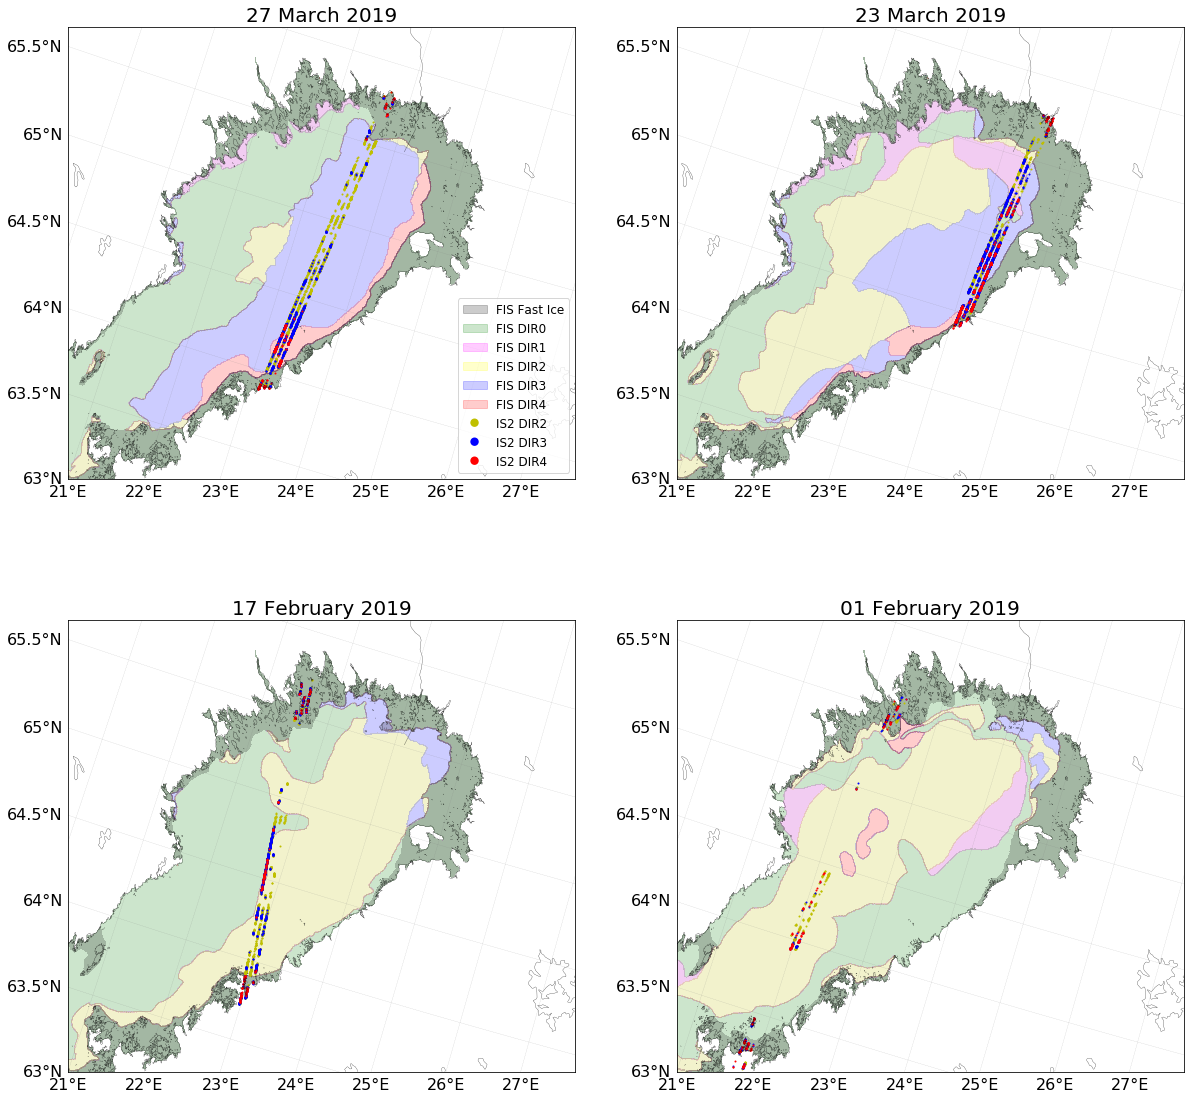

In [43]:
def plot_chart_data(ax, lat2, lon2, data2, df, df2, df3, text = None, lat3 = None, lon3 = None, data3 = None, legend_yn = None):
    import matplotlib.patches as mpatches
    from matplotlib.legend_handler import HandlerPatch
    
    class HandlerEllipse(HandlerPatch):
        def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
            center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
            p = mpatches.Ellipse(xy=center, width=height + xdescent,
                                 height=height + ydescent)
            self.update_prop(p, orig_handle, legend)
            p.set_transform(trans)
            return [p]
    
    m = Basemap(llcrnrlon=21.,llcrnrlat=63.,urcrnrlon=26.,urcrnrlat=66.5,
        projection='lcc', lat_1=22.,lat_2=27,lon_0=64.5,
        resolution ='h',area_thresh=0)
    m.drawcoastlines(linewidth=0.25)
    m.drawcountries(linewidth=0.25)

    parallels = np.arange(-85.,85,0.5)
    meridians = np.arange(0.,360.,1)
    m.drawparallels(parallels,color="gray", linewidth=0.2, labels=[True,0,0,0], fontsize = 16)
    m.drawmeridians(meridians,color="gray", linewidth=0.2, labels=[0,0,0,True], fontsize = 16)

    xx, yy = np.meshgrid(lon2, lat2)

    cs = m.contourf(xx,yy, data2, latlon = True, levels = [-1, 0, 1, 2, 3, 4], colors=['g', 'm', 'y', 'b', 'r', 'k'], alpha = 0.2)
    
    xx, yy = np.meshgrid(lon3, lat3)
    cs2 = m.contourf(xx,yy, data3, latlon = True, levels = [8,9] ,corner_mask = 'legacy',colors = ['k', 'k'], alpha = 0.2)
    
    #m.fillcontinents('tab:gray', alpha = 0.4)
    
    if legend_yn is True:
        DIR0 = mpatches.Patch(color = 'green', alpha = 0.2, label = 'FIS DIR0')
        DIR1 = mpatches.Patch(color = 'magenta', alpha = 0.2, label = 'FIS DIR1')
        DIR2 = mpatches.Patch(color = 'yellow', alpha = 0.2, label = 'FIS DIR2')
        DIR3 = mpatches.Patch(color = 'blue', alpha = 0.2, label = 'FIS DIR3')
        DIR4 = mpatches.Patch(color = 'red', alpha = 0.2, label = 'FIS DIR4')
        FI_FIS = mpatches.Patch(color = 'k', alpha = 0.2, label = 'FIS Fast Ice')
        IS2_DIR2 = mpatches.Circle((0.5, 0.5), radius = 0.25, facecolor = 'y', edgecolor = 'none', label = 'IS2 DIR2')
        IS2_DIR3 = mpatches.Circle((0.5, 0.5), radius = 0.25, facecolor = 'b', edgecolor = 'none', label = 'IS2 DIR3')
        IS2_DIR4 = mpatches.Circle((0.5, 0.5), radius = 0.25, facecolor = 'r', edgecolor = 'none', label = 'IS2 DIR4')
        plt.legend(handles=[FI_FIS, DIR0, DIR1, DIR2, DIR3, DIR4, IS2_DIR2, IS2_DIR3, IS2_DIR4], loc = 'lower right', fontsize = 12, handler_map = {mpatches.Circle: HandlerEllipse()})

    x,y = m(np.array(df['lon'].dropna()), np.array(df['lat'].dropna()))
    m.scatter(x,y,s = 1,c='y', vmin = 2, vmax = 4)
    x,y = m(np.array(df2['lon'].dropna()), np.array(df2['lat'].dropna()))
    m.scatter(x,y,s = 1,c='b', vmin = 2, vmax = 4)
    x,y = m(np.array(df3['lon'].dropna()), np.array(df3['lat'].dropna()))
    m.scatter(x,y,s = 1,c='r', vmin = 2, vmax = 4)
    
    
    plt.title(text, fontsize = 20)
    
fig, ax10 = plt.subplots(figsize=(20,20))

df_result_gt1l = pd.read_csv('D:/ICESat-2/res_gt1l_27032019_non_correct.csv')
df_result_gt1r = pd.read_csv('D:/ICESat-2/res_gt1r_27032019_non_correct.csv')
df_result_gt2l = pd.read_csv('D:/ICESat-2/res_gt2l_27032019_non_correct.csv')
df_result_gt2r = pd.read_csv('D:/ICESat-2/res_gt2r_27032019_non_correct.csv')
df_result_gt3l = pd.read_csv('D:/ICESat-2/res_gt3l_27032019_non_correct.csv')
df_result_gt3r = pd.read_csv('D:/ICESat-2/res_gt3r_27032019_non_correct.csv')

n = 2  
frames = [df_result_gt1l[df_result_gt1l['cat'] == n], df_result_gt2l[df_result_gt2l['cat'] == n], df_result_gt3l[df_result_gt3l['cat'] == n]]
GTL_per_2 = pd.concat(frames)

n = 3  
frames = [df_result_gt1l[df_result_gt1l['cat'] == n], df_result_gt2l[df_result_gt2l['cat'] == n], df_result_gt3l[df_result_gt3l['cat'] == n]]
GTL_per_3 = pd.concat(frames)

n = 4  
frames = [df_result_gt1l[df_result_gt1l['cat'] == n], df_result_gt2l[df_result_gt2l['cat'] == n], df_result_gt3l[df_result_gt3l['cat'] == n]]
GTL_per_4 = pd.concat(frames)

ax1 = plt.subplot2grid((2,2), (0,0))
plot_chart_data(ax1, lat_27032019, lon_27032019, data_27032019, GTL_per_2, GTL_per_3, GTL_per_4, '27 March 2019', lat2_27032019, lon2_27032019, data2_27032019, legend_yn = True)

df_result_gt1l = pd.read_csv('D:/ICESat-2/res_gt1l_23032019_non_correct.csv')
df_result_gt1r = pd.read_csv('D:/ICESat-2/res_gt1r_23032019_non_correct.csv')
df_result_gt2l = pd.read_csv('D:/ICESat-2/res_gt2l_23032019_non_correct.csv')
df_result_gt2r = pd.read_csv('D:/ICESat-2/res_gt2r_23032019_non_correct.csv')
df_result_gt3l = pd.read_csv('D:/ICESat-2/res_gt3l_23032019_non_correct.csv')
df_result_gt3r = pd.read_csv('D:/ICESat-2/res_gt3r_23032019_non_correct.csv')

n = 2  
frames = [df_result_gt1l[df_result_gt1l['cat'] == n], df_result_gt2l[df_result_gt2l['cat'] == n], df_result_gt3l[df_result_gt3l['cat'] == n]]
GTL_per_2 = pd.concat(frames)

n = 3  
frames = [df_result_gt1l[df_result_gt1l['cat'] == n], df_result_gt2l[df_result_gt2l['cat'] == n], df_result_gt3l[df_result_gt3l['cat'] == n]]
GTL_per_3 = pd.concat(frames)

n = 4  
frames = [df_result_gt1l[df_result_gt1l['cat'] == n], df_result_gt2l[df_result_gt2l['cat'] == n], df_result_gt3l[df_result_gt3l['cat'] == n]]
GTL_per_4 = pd.concat(frames)

ax1 = plt.subplot2grid((2,2), (0,1))
plot_chart_data(ax1, lat_23032019, lon_23032019, data_23032019, GTL_per_2, GTL_per_3, GTL_per_4, '23 March 2019',lat2_23032019, lon2_23032019, data2_23032019)

df_result_gt1l = pd.read_csv('D:/ICESat-2/res_gt1l_17022019_non_correct.csv')
df_result_gt1r = pd.read_csv('D:/ICESat-2/res_gt1r_17022019_non_correct.csv')
df_result_gt2l = pd.read_csv('D:/ICESat-2/res_gt2l_17022019_non_correct.csv')
df_result_gt2r = pd.read_csv('D:/ICESat-2/res_gt2r_17022019_non_correct.csv')
df_result_gt3l = pd.read_csv('D:/ICESat-2/res_gt3l_17022019_non_correct.csv')
df_result_gt3r = pd.read_csv('D:/ICESat-2/res_gt3r_17022019_non_correct.csv')

n = 2  
frames = [df_result_gt1l[df_result_gt1l['cat'] == n], df_result_gt2l[df_result_gt2l['cat'] == n], df_result_gt3l[df_result_gt3l['cat'] == n]]
GTL_per_2 = pd.concat(frames)

n = 3  
frames = [df_result_gt1l[df_result_gt1l['cat'] == n], df_result_gt2l[df_result_gt2l['cat'] == n], df_result_gt3l[df_result_gt3l['cat'] == n]]
GTL_per_3 = pd.concat(frames)

n = 4  
frames = [df_result_gt1l[df_result_gt1l['cat'] == n], df_result_gt2l[df_result_gt2l['cat'] == n], df_result_gt3l[df_result_gt3l['cat'] == n]]
GTL_per_4 = pd.concat(frames)

ax1 = plt.subplot2grid((2,2), (1,0))
plot_chart_data(ax1, lat_17022019, lon_17022019, data_17022019, GTL_per_2, GTL_per_3, GTL_per_4, '17 February 2019',lat2_17022019, lon2_17022019, data2_17022019)

df_result_gt1l = pd.read_csv('D:/ICESat-2/res_gt1l_01022019_non_correct.csv')
df_result_gt1r = pd.read_csv('D:/ICESat-2/res_gt1r_01022019_non_correct.csv')
df_result_gt2l = pd.read_csv('D:/ICESat-2/res_gt2l_01022019_non_correct.csv')
df_result_gt2r = pd.read_csv('D:/ICESat-2/res_gt2r_01022019_non_correct.csv')
df_result_gt3l = pd.read_csv('D:/ICESat-2/res_gt3l_01022019_non_correct.csv')
df_result_gt3r = pd.read_csv('D:/ICESat-2/res_gt3r_01022019_non_correct.csv')

n = 2  
frames = [df_result_gt1l[df_result_gt1l['cat'] == n], df_result_gt2l[df_result_gt2l['cat'] == n], df_result_gt3l[df_result_gt3l['cat'] == n]]
GTL_per_2 = pd.concat(frames)

n = 3  
frames = [df_result_gt1l[df_result_gt1l['cat'] == n], df_result_gt2l[df_result_gt2l['cat'] == n], df_result_gt3l[df_result_gt3l['cat'] == n]]
GTL_per_3 = pd.concat(frames)

n = 4  
frames = [df_result_gt1l[df_result_gt1l['cat'] == n], df_result_gt2l[df_result_gt2l['cat'] == n], df_result_gt3l[df_result_gt3l['cat'] == n]]
GTL_per_4 = pd.concat(frames)

ax1 = plt.subplot2grid((2,2), (1,1))
plot_chart_data(ax1, lat_01022019, lon_01022019, data_01022019, GTL_per_2, GTL_per_3, GTL_per_4, '01 February 2019',lat2_01022019, lon2_01022019, data2_01022019)

path = 'D:/ICESat-2/'
end = '.jpg'
plt.savefig(path+'distr_total'+end, dpi = 300)

# Plot a proxy for ridge density (300 strips of surface anomalies)

C:\Users\renee\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\renee\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


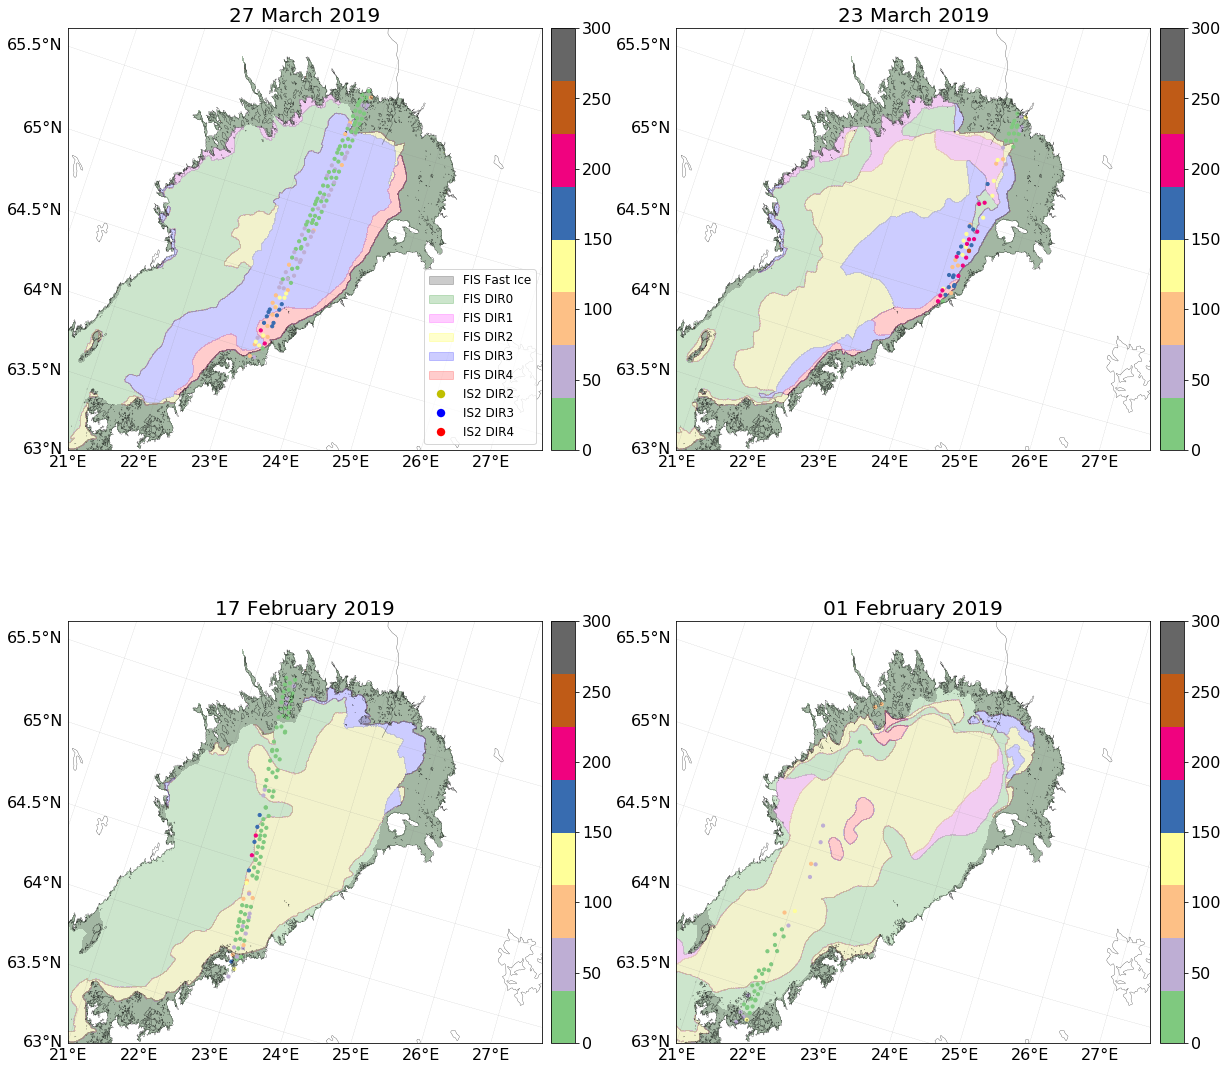

In [44]:
## 300 strips

def plot_chart_data(ax, lat2, lon2, data2, df, text = None, lat3 = None, lon3 = None, data3 = None, legend_yn = None):
    import matplotlib.patches as mpatches
    from matplotlib.legend_handler import HandlerPatch
    
    class HandlerEllipse(HandlerPatch):
        def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
            center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
            p = mpatches.Ellipse(xy=center, width=height + xdescent,
                                 height=height + ydescent)
            self.update_prop(p, orig_handle, legend)
            p.set_transform(trans)
            return [p]
    
    m = Basemap(llcrnrlon=21.,llcrnrlat=63.,urcrnrlon=26.,urcrnrlat=66.5,
        projection='lcc', lat_1=22.,lat_2=27,lon_0=64.5,
        resolution ='h',area_thresh=0)
    m.drawcoastlines(linewidth=0.25)
    m.drawcountries(linewidth=0.25)

    parallels = np.arange(-85.,85,0.5)
    meridians = np.arange(0.,360.,1)
    m.drawparallels(parallels,color="gray", linewidth=0.2, labels=[True,0,0,0], fontsize = 16)
    m.drawmeridians(meridians,color="gray", linewidth=0.2, labels=[0,0,0,True], fontsize = 16)

    xx, yy = np.meshgrid(lon2, lat2)

    cs = m.contourf(xx,yy, data2, latlon = True, levels = [-1, 0, 1, 2, 3, 4], colors=['g', 'm', 'y', 'b', 'r', 'k'], alpha = 0.2)

    labels = ['DIR1', 'DIR2', 'DIR3', 'DIR4','Coastline']
    #for i in range(len(labels)):
    #    cs.collections[i].set_label(labels[i])
    
    xx, yy = np.meshgrid(lon3, lat3)
    cs2 = m.contourf(xx,yy, data3, latlon = True, levels = [8,9] ,corner_mask = 'legacy',colors = ['k', 'k'], alpha = 0.2)
    
    if legend_yn is True:
        DIR0 = mpatches.Patch(color = 'green', alpha = 0.2, label = 'FIS DIR0')
        DIR1 = mpatches.Patch(color = 'magenta', alpha = 0.2, label = 'FIS DIR1')
        DIR2 = mpatches.Patch(color = 'yellow', alpha = 0.2, label = 'FIS DIR2')
        DIR3 = mpatches.Patch(color = 'blue', alpha = 0.2, label = 'FIS DIR3')
        DIR4 = mpatches.Patch(color = 'red', alpha = 0.2, label = 'FIS DIR4')
        FI_FIS = mpatches.Patch(color = 'k', alpha = 0.2, label = 'FIS Fast Ice')
        IS2_DIR2 = mpatches.Circle((0.5, 0.5), radius = 0.25, facecolor = 'y', edgecolor = 'none', label = 'IS2 DIR2')
        IS2_DIR3 = mpatches.Circle((0.5, 0.5), radius = 0.25, facecolor = 'b', edgecolor = 'none', label = 'IS2 DIR3')
        IS2_DIR4 = mpatches.Circle((0.5, 0.5), radius = 0.25, facecolor = 'r', edgecolor = 'none', label = 'IS2 DIR4')
        plt.legend(handles=[FI_FIS, DIR0, DIR1, DIR2, DIR3, DIR4, IS2_DIR2, IS2_DIR3, IS2_DIR4], loc = 'lower right', fontsize = 12, handler_map = {mpatches.Circle: HandlerEllipse()})

    #m.fillcontinents('tab:gray', alpha = 0.4)

    x,y = m(np.array(df['lon'].dropna()), np.array(df['lat'].dropna()))
    m.scatter(x,y,s = 10,c=np.array(df['cat'].dropna()), vmin = 0, vmax = 300, cmap = 'Accent')
    cb = m.colorbar()
    
    plt.title(text, fontsize = 20)
    cb.ax.tick_params(labelsize=16) 

    
fig, ax10 = plt.subplots(figsize=(20,20))

df_result_gt1l = pd.read_csv('D:/ICESat-2/res3_gt1l_27032019_non_correct.csv')
df_result_gt1r = pd.read_csv('D:/ICESat-2/res3_gt1r_27032019_non_correct.csv')
df_result_gt2l = pd.read_csv('D:/ICESat-2/res3_gt2l_27032019_non_correct.csv')
df_result_gt2r = pd.read_csv('D:/ICESat-2/res3_gt2r_27032019_non_correct.csv')
df_result_gt3l = pd.read_csv('D:/ICESat-2/res3_gt3l_27032019_non_correct.csv')
df_result_gt3r = pd.read_csv('D:/ICESat-2/res3_gt3r_27032019_non_correct.csv')


frames = [df_result_gt1l, df_result_gt2l, df_result_gt3l, df_result_gt1r, df_result_gt2r, df_result_gt3r]
GTL_per = pd.concat(frames)
ax1 = plt.subplot2grid((2,2), (0,0))
plot_chart_data(ax1, lat_27032019, lon_27032019, data_27032019, GTL_per, '27 March 2019', lat2_27032019, lon2_27032019, data2_27032019, legend_yn = True)

df_result_gt1l = pd.read_csv('D:/ICESat-2/res3_gt1l_23032019_non_correct.csv')
df_result_gt1r = pd.read_csv('D:/ICESat-2/res3_gt1r_23032019_non_correct.csv')
df_result_gt2l = pd.read_csv('D:/ICESat-2/res3_gt2l_23032019_non_correct.csv')
df_result_gt2r = pd.read_csv('D:/ICESat-2/res3_gt2r_23032019_non_correct.csv')
df_result_gt3l = pd.read_csv('D:/ICESat-2/res3_gt3l_23032019_non_correct.csv')
df_result_gt3r = pd.read_csv('D:/ICESat-2/res3_gt3r_23032019_non_correct.csv')

frames = [df_result_gt1l, df_result_gt2l, df_result_gt3l, df_result_gt1r, df_result_gt2r, df_result_gt3r]
GTL_per = pd.concat(frames)
ax1 = plt.subplot2grid((2,2), (0,1))
plot_chart_data(ax1, lat_23032019, lon_23032019, data_23032019, GTL_per, '23 March 2019',lat2_23032019, lon2_23032019, data2_23032019)

df_result_gt1l = pd.read_csv('D:/ICESat-2/res3_gt1l_17022019_non_correct.csv')
df_result_gt1r = pd.read_csv('D:/ICESat-2/res3_gt1r_17022019_non_correct.csv')
df_result_gt2l = pd.read_csv('D:/ICESat-2/res3_gt2l_17022019_non_correct.csv')
df_result_gt2r = pd.read_csv('D:/ICESat-2/res3_gt2r_17022019_non_correct.csv')
df_result_gt3l = pd.read_csv('D:/ICESat-2/res3_gt3l_17022019_non_correct.csv')
df_result_gt3r = pd.read_csv('D:/ICESat-2/res3_gt3r_17022019_non_correct.csv')

frames = [df_result_gt1l, df_result_gt2l, df_result_gt3l, df_result_gt1r, df_result_gt2r, df_result_gt3r]
GTL_per = pd.concat(frames)
ax1 = plt.subplot2grid((2,2), (1,0))
plot_chart_data(ax1, lat_17022019, lon_17022019, data_17022019, GTL_per, '17 February 2019',lat2_17022019, lon2_17022019, data2_17022019)

df_result_gt1l = pd.read_csv('D:/ICESat-2/res3_gt1l_01022019_non_correct.csv')
df_result_gt1r = pd.read_csv('D:/ICESat-2/res3_gt1r_01022019_non_correct.csv')
df_result_gt2l = pd.read_csv('D:/ICESat-2/res3_gt2l_01022019_non_correct.csv')
df_result_gt2r = pd.read_csv('D:/ICESat-2/res3_gt2r_01022019_non_correct.csv')
df_result_gt3l = pd.read_csv('D:/ICESat-2/res3_gt3l_01022019_non_correct.csv')
df_result_gt3r = pd.read_csv('D:/ICESat-2/res3_gt3r_01022019_non_correct.csv')

frames = [df_result_gt1l, df_result_gt2l, df_result_gt3l, df_result_gt1r, df_result_gt2r, df_result_gt3r]
GTL_per = pd.concat(frames)
ax1 = plt.subplot2grid((2,2), (1,1))
plot_chart_data(ax1, lat_01022019, lon_01022019, data_01022019, GTL_per, '01 February 2019',lat2_01022019, lon2_01022019, data2_01022019)

path = 'D:/ICESat-2/'
end = '.jpg'
plt.savefig(path+'distr_counts'+end, dpi = 300)